# Unsupervised Clustering Methods for Meteorological European Configurations/ Patterns


<span style="color: red;">- ORA MODIFICO IL MODO DI STANDARDIZZARE -> STANDARDIZZAZIONE GLOBALE così:</span>
- Preservati i rapporti relativi: z_250 resta sempre > z_500 > z_850
- Mantiengo le distanze verticali: spessore della troposfera conservato
- Conservo la stagionalità: inverno vs estate mantengono le differenze assolute
- problemi numerici risolti: tutte le feature hanno scala simile per PCA/clustering


In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import shapefile as shp
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
import matplotlib.cm as cm


#from sklearn.decomposition import IncrementalPCA
from sklearn.cluster import KMeans

import importlib
import utils.data_processing
import utils.visualization
importlib.reload(utils.data_processing)
importlib.reload(utils.visualization)

# Import delle funzioni personalizzate
from utils.data_processing import prepare_data_matrix, apply_global_standardization, perform_incremental_pca
from utils.visualization import plot_variance, scatter_plot_2d,scatter_plot_3d,  add_country_boundaries
from utils.visualization import visualization_pca_coefficient

## 1 Data Loading and Initial Analysis

The dataset used in this analysis consists of ERA5 reanalysis data downloaded from the Copernicus Climate Data Store (CDS). ERA5 is the fifth generation ECMWF atmospheric reanalysis providing comprehensive meteorological data with high spatial and temporal resolution. The dataset covers a 5-year period from January 1, 2000 to December 31, 2004, focusing on the European region. It includes four key atmospheric variables: geopotential height (z), temperature (t), and horizontal wind components (u, v), measured at three pressure levels (850 hPa, 500 hPa, and 250 hPa) on a regular 0.25° × 0.25° grid. This high-resolution gridded data provides a comprehensive representation of European atmospheric patterns and will be used to identify meteorological configurations through unsupervised clustering methods.

In [2]:
# Load the dataset
ds = xr.open_dataset('era5_ridotto.grib', engine= 'cfgrib') # XArray DataSet
print("Overview of the dataset:")
print(f"   • Variables: {list(ds.data_vars.keys())}")
print(f"   • Coordinates: {list(ds.coords.keys())}")

Overview of the dataset:
   • Variables: ['z']
   • Coordinates: ['number', 'time', 'step', 'isobaricInhPa', 'latitude', 'longitude', 'valid_time']


In [3]:
# Dimenision details
print("Dimension details:")
if 'latitude' in ds.dims:
    print(f"   • Latitude: {ds.dims['latitude']} points ({ds.latitude.min().values:.1f}° - {ds.latitude.max().values:.1f}°)")
if 'longitude' in ds.dims:
    print(f"   • Longitude: {ds.dims['longitude']} points ({ds.longitude.min().values:.1f}° - {ds.longitude.max().values:.1f}°)")
if 'time' in ds.dims:
    print(f"   • Time: {ds.dims['time']} steps ({pd.to_datetime(ds.time.values[0]).strftime('%Y-%m-%d')} - {pd.to_datetime(ds.time.values[-1]).strftime('%Y-%m-%d')})")
if 'isobaricInhPa' in ds.dims:
    print(f"   • Pressure levels: {ds.dims['isobaricInhPa']} levels ({list(ds.isobaricInhPa.values)} hPa)")

#Variables 
print("Variables in the dataset:")
for var in ds.data_vars:
    var_data = ds[var]
    print(f"   • {var}: {var_data.dims} - {var_data.attrs.get('long_name', 'N/A')}")
    print(f"     └─ Units: {var_data.attrs.get('units', 'N/A')}")

Dimension details:
   • Latitude: 201 points (20.0° - 70.0°)
   • Longitude: 321 points (-40.0° - 40.0°)
   • Time: 1827 steps (2000-01-01 - 2004-12-31)
   • Pressure levels: 3 levels ([np.float64(850.0), np.float64(500.0), np.float64(250.0)] hPa)
Variables in the dataset:
   • z: ('time', 'isobaricInhPa', 'latitude', 'longitude') - Geopotential
     └─ Units: m**2 s**-2


In [4]:
# Total dimensionality
total_spatial_points = 1
for dim in ['latitude', 'longitude']:
    if dim in ds.dims:
        total_spatial_points *= ds.dims[dim]

total_features = len(ds.data_vars) * ds.dims.get('isobaricInhPa', 1) * total_spatial_points
print("DIMENSIONALITY:")
print(f" • Spatial points: {total_spatial_points}")
print(f" • Total features per timestep: {total_features:,}")
print(f" • Temporal samples: {ds.dims.get('time', 1)}")

DIMENSIONALITY:
 • Spatial points: 64521
 • Total features per timestep: 193,563
 • Temporal samples: 1827


In [5]:
# Missing values check: already verified to be 0
print("MISSING VALUES: No missing values (previously verified)")

MISSING VALUES: No missing values (previously verified)


There are no missing values in the dataset

## 2 Preprocessing and Feature Selection

### 2.1 Preparing Data Matrix

#### Initial data structure

Our dataset consists of geopotential height (z) measurements organized as a 4-dimensional array. The structure of this array is: a temporal dimension of 1827 daily observations from 1.01.2000 to 31.12.2004; a spatial dimension of 64521 points given by 201 latitude values x 321 longitude values and a vertical dimension given by the fact that the measurements are taken at 3 different atmospheric pressure levels ( 850 hPa, 500 hPa, 250 hPa).  
The data are organized in a nested structure where for each pressure level, measurements are recorded at every latitude-longitude grid point across the European region. 

_ _ _ - - _ _ _ (  
**Scatola** = Dataset   
dentro la scatola di sono dei blocchi di fogli  
**Un blocco di fogli** = un signolo giorno ( da 1 gennaio 2000 a 31 dic 2004)  -> <span style="color: red;">1827 giorni</span>  
il blocco di fogli è formato da 1 foglio   
**Un foglio contiene i valori di una variabile** =  variabile: z -> <span style="color: red;">1 variabile</span>  

Ogni foglio contiene i valori di quella variabile presi in ogni singolo punto dello 'spazio' definito dalla longitudine e dalla laitudine. Quindi in ogni foglio c'è il valore di quella variabile in ognuno dei 201(lat) × 321(lon). Una specie di tabella.  -> <span style="color: red;">64521 punti spaziali</span>

**Solo che questa tabella di valori è presa per ognuno dei 3 livelli di pressione** = 850 hPa, 500 hPa, 250 hPa -> <span style="color: red;">3 lv di pressione</span>

**TOT= 193,563 valori per blocco**   x 1827 giorni

Per la variabile z: 
__per ogni livello di pressione:  
____per ogni lat:  
______per ogni lon:  
________prendi il valore  

Se penso al foglio come una tabella con 193,563 colonne, e solo 1 riga, che rappresenta tutte le misure spaziali per quel giorno, posso mettere insieme tutti i 1827 fogli, e ottenere una matrice finale di forma (1827, 193,563). Ogni riga è un giorno. Ogni colonna è una variabile a una certa posizione e pressione.  
_ _ _ - - _ _ _ )


#### Final data structure

For our following analysis we need to reshape this multimensional matrix into a 2D matrix. The temporal dimension will remain the same, each column, instead, will become a combination of the geopotential height at a specific spatial location (latitude-longitude pair) and pressure level.

           feature_1  feature_2  ...  feature_193,563 
time_1 →      ...        ...             ...  
time_2 →      ...        ...             ...  
  ⋮                             
time_1827 →   ...        ...             ...  


In [6]:
print("PREPARING DATA MATRIX")
X, data_matrices = prepare_data_matrix(ds)
print(f"Data Matrix: {X.shape} (samples, features)")

PREPARING DATA MATRIX
   • Processing z...
Data Matrix: (1827, 193563) (samples, features)


### 2.2 Standardization

For the standardization process, we initially implemented a per-feature standardization approach, where each spatial point was normalized with respect to its local temporal variability. However, this approach presents a significant limitation: all physical relationships between pressure levels (z₂₅₀ > z₅₀₀ > z₈₅₀) are lost, and the vertical structure of the troposphere becomes distorted.

To address this issue, we adopted a global standardization approach. This method preserves the relative relationships between pressure levels and maintains the atmospheric depth structure. Additionally, it ensures that all features have comparable scales, which is essential for subsequent analyses such as PCA and clustering, while retaining the meteorological interpretability of the data.

In [7]:
print("GLOBAL STANDARDIZATION")

# Applica standardizzazione globale usando la funzione da utils
X, global_mean, global_std = apply_global_standardization(X)

print("Before standardization:")
print(f"Global mean: {global_mean:.2f}m")
print(f"Global std: {global_std:.2f}m")
print(f"Dataset shape: {X.shape}")

print("After standardization:")
print(f" • New global mean: {X.mean():.6f}")
print(f" • New global std: {X.std():.6f}")

# Verify some sample statistics
print(f" • Sample min: {X.min():.3f}")
print(f" • Sample max: {X.max():.3f}")

GLOBAL STANDARDIZATION
Before standardization:
Global mean: 57405.69m
Global std: 36090.11m
Dataset shape: (1827, 193563)
After standardization:
 • New global mean: 0.000007
 • New global std: 0.999999
 • Sample min: -1.383
 • Sample max: 1.424


Now, an esample of standardization for 3 points is shown.

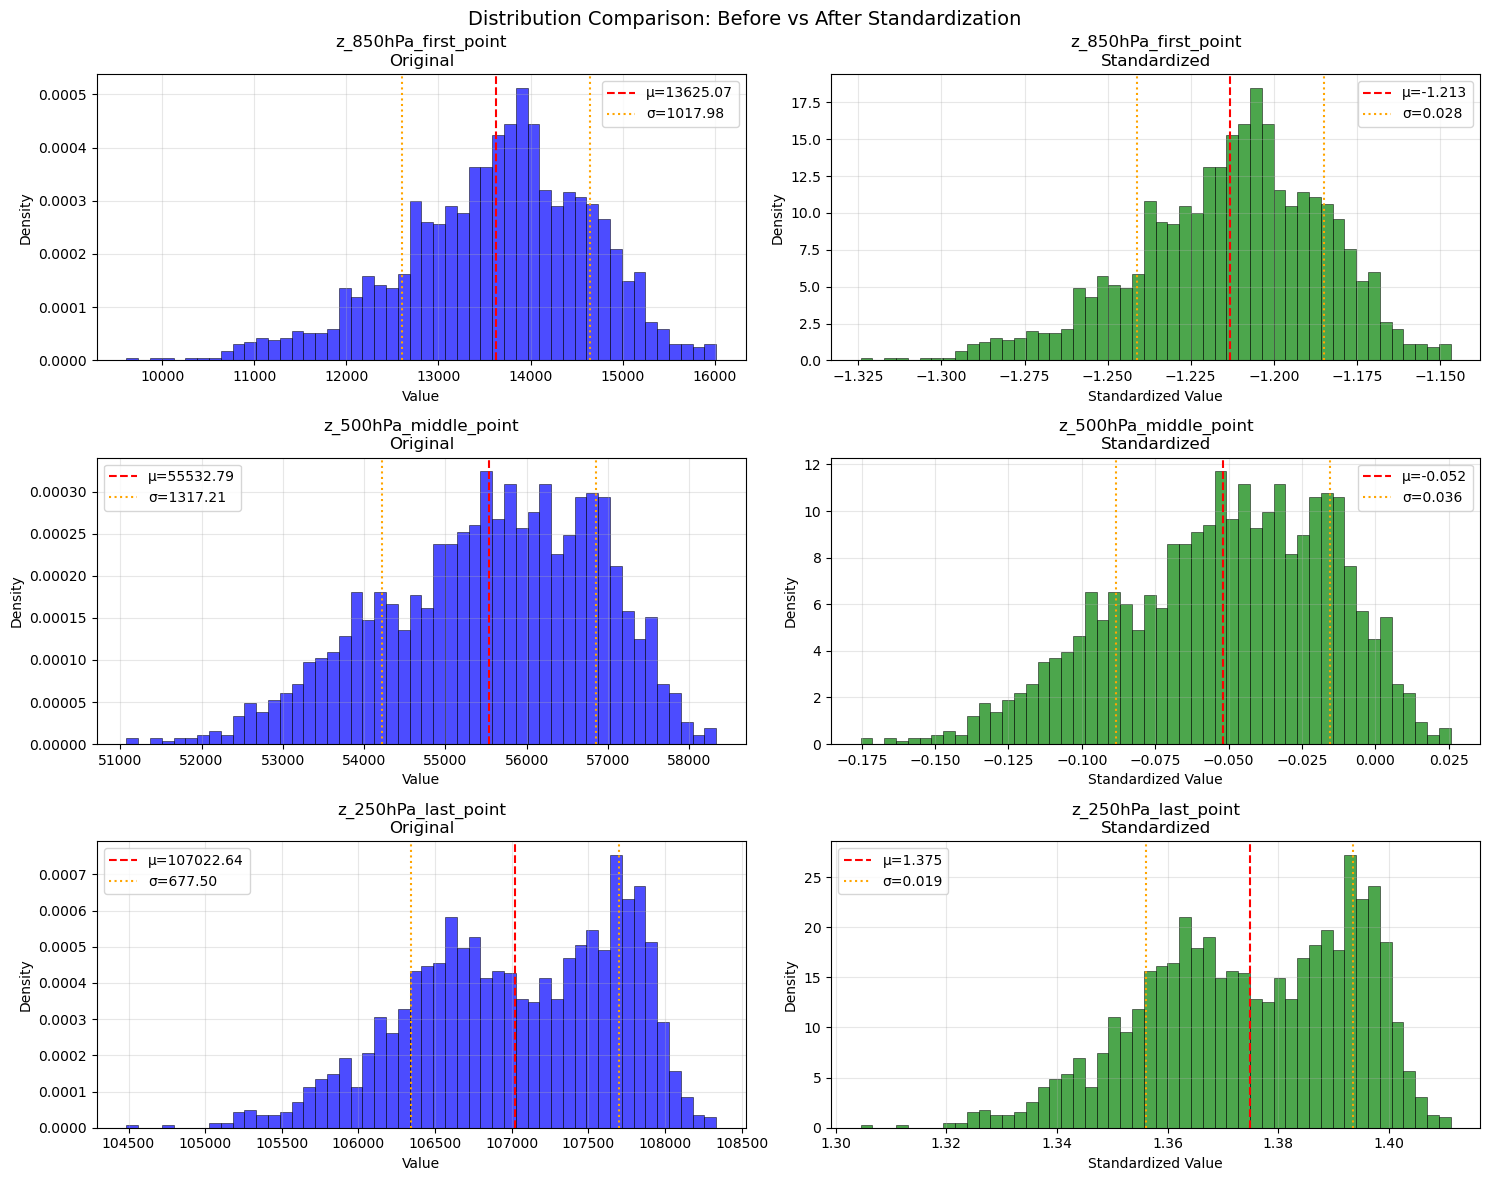

### 2.3 Principal Component Analysis

For the Principal Component Analysis, we implemented an incremental PCA approach to avoid potential memory and numerical issues when dealing with large datasets. The incremental PCA processes data in batches while maintaining mathematical equivalence to standard PCA, ensuring convergence to identical results.

The primary objective of PCA is to represent the dataset in a lower-dimensional space using a reduced number of variables (principal components) while preserving as much variance (information) as possible from the original data. This dimensionality reduction technique enables us to capture the most significant patterns of atmospheric variability while reducing computational complexity for subsequent clustering analysis.



**Varianza = quanto i dati si "spargono" attorno alla media**
- La PCA cerca le **direzioni di MASSIMA varianza**   
- Trova i pattern meteorologici che cambiano di più nel tempo  
- Cattura le configurazioni atmosferiche principali (NAO, anticicloni, ecc.)  

<span style="color: orange;"> La PCA non assegna etichette o categorie: ogni campione rimane un punto nello spazio, solo rappresentato in modo più efficiente. Le componenti non sono cluster, ma assi cartesiani scelti in modo che la varianza sia massima lungo il primo asse, poi il secondo ecc. Quindi la PCA non è un clustering, anche se può rivelare struttura nei dati.

Principal components are a sequence of projections of the data, mutually uncorrelated and ordered in variance.   
The principal components of a set of data in IRp provide a sequence of best
linear approximations to that data, of all ranks q ≤ p.  
(BookAdvanced, pg 553)

In [8]:
print("INCREMENTAL PCA ANALYSIS")

n_components = 30   # Reduced to 60 components for safety with batch processing
batch_size = 100    # Increased batch size to accommodate more components

print(f"   • Target components: {n_components}")
print(f"   • Batch size: {batch_size}")
print(f"   • Data shape: {X.shape}")
 
X_pca, ipca, explained_variance_ratio, cumulative_variance = perform_incremental_pca(X, n_components=n_components, batch_size=batch_size)

INCREMENTAL PCA ANALYSIS
   • Target components: 30
   • Batch size: 100
   • Data shape: (1827, 193563)
   • Target components: 30
   • Batch size: 100
   • Data shape: (1827, 193563)


   • Original shape: (1827, 193563)
   • PCA shape: (1827, 30)

   • VARIANCE ANALYSIS:
   • Total explained variance (30 components): 0.977
   • 80.0% variance: 5 components
   • 85.0% variance: 6 components
   • 90.0% variance: 9 components
   • 95.0% variance: 17 components

   • First 10 components variance: [0.54175443 0.09899399 0.08343008 0.06019424 0.0448536  0.02799979
 0.01898389 0.01710956 0.01276842 0.00937222]
   • First 30 components cumulative: 0.977


La PCA con 30 componenti spiega l’97.7% della varianza totale.  

Il grafico mostra chiaramente un forte “elbow” nei primi componenti: la prima componente da sola spiega il 54.2% (!), la seconda il 9.9%, e poi via via la varianza scende rapidamente → significa che gran parte dell’informazione è concentrata nei primi componenti

VARIANCE VISUALIZATION


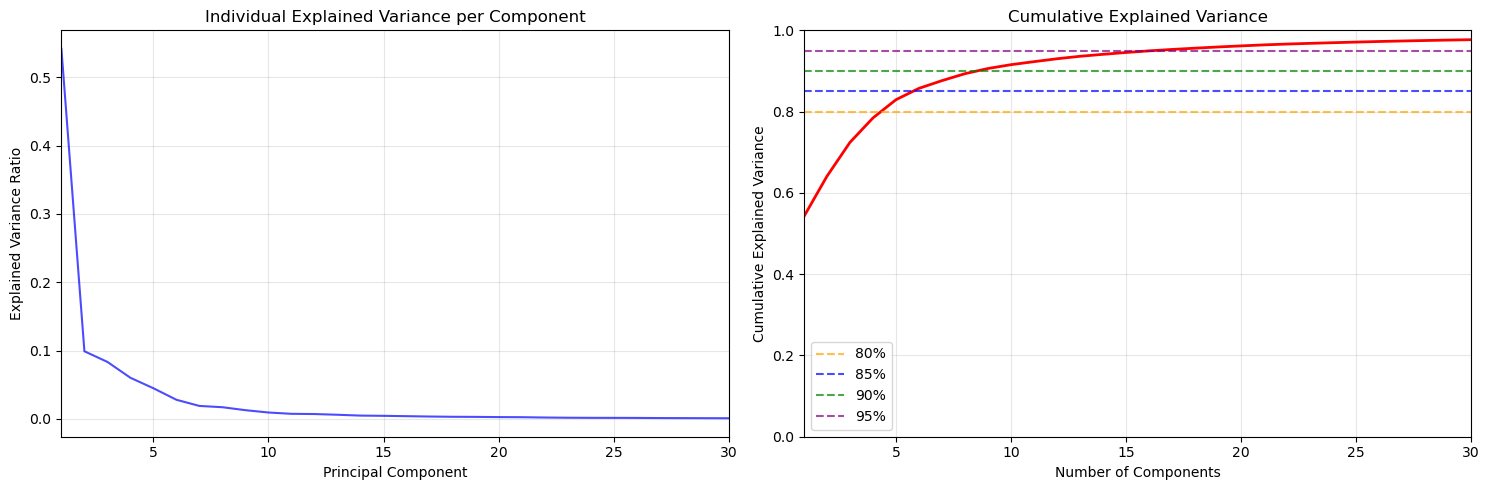

In [9]:
# Visualization of explained variance
print("VARIANCE VISUALIZATION")

# Create plots for variance analysis

plot_variance(explained_variance_ratio, cumulative_variance, n_components)


grafico a sinistra: varianza spiegata per singola componente
(di solito decresce velocemente, “elbow” shape)  
mostra la varianza spiegata da ciascun componente  
conferma che la prima componente è molto informativa  
curva a gomito → tipico nei dati ridondanti

grafico a destra: varianza spiegata cumulata
(sale a gradini, fino a saturare verso 1)  
mostra la varianza cumulata
le linee orizzontali (80%, 90%, 95%)   
la curva rossa sale rapidamente ma si stabilizza, quindi i componenti successivi hanno impatto minore

<span style="color: orange;">la PCA permette di proiettare i dati in un nuovo spazio ridotto che mantiene la maggior parte dell’informazione
Inoltre, facilita interpretazioni fisiche (ad esempio i primi componenti possono corrispondere a pattern meteorologici dominanti) e riduce il rumore e la ridondanza tra variabili</span>

In [10]:
n_components_final = 30  # Final number of components based on variance analysis
print(f"   • Original data shape: {X.shape}")
print(f"   • PCA full shape: {X_pca.shape}")
 
variance_explained = cumulative_variance[n_components_final-1]
print(f"   • Actual variance explained: {variance_explained:.3f} ({variance_explained*100:.1f}%)")


   • Original data shape: (1827, 193563)
   • PCA full shape: (1827, 30)
   • Actual variance explained: 0.977 (97.7%)


#### 2.3.1 Visualization of the first components

I plots 2D/3D servono per:

- PC1 vs PC2: scatter plot per vedere se ci sono cluster naturali
- PC1 vs PC2 vs PC3: scatter 3D per pattern più complessi
- Istogrammi delle prime 4-5 componenti  
Se vedo "nuvole" separate → suggerisce struttura a cluster

VISUALIZATION OF PRINCIPAL COMPONENTS


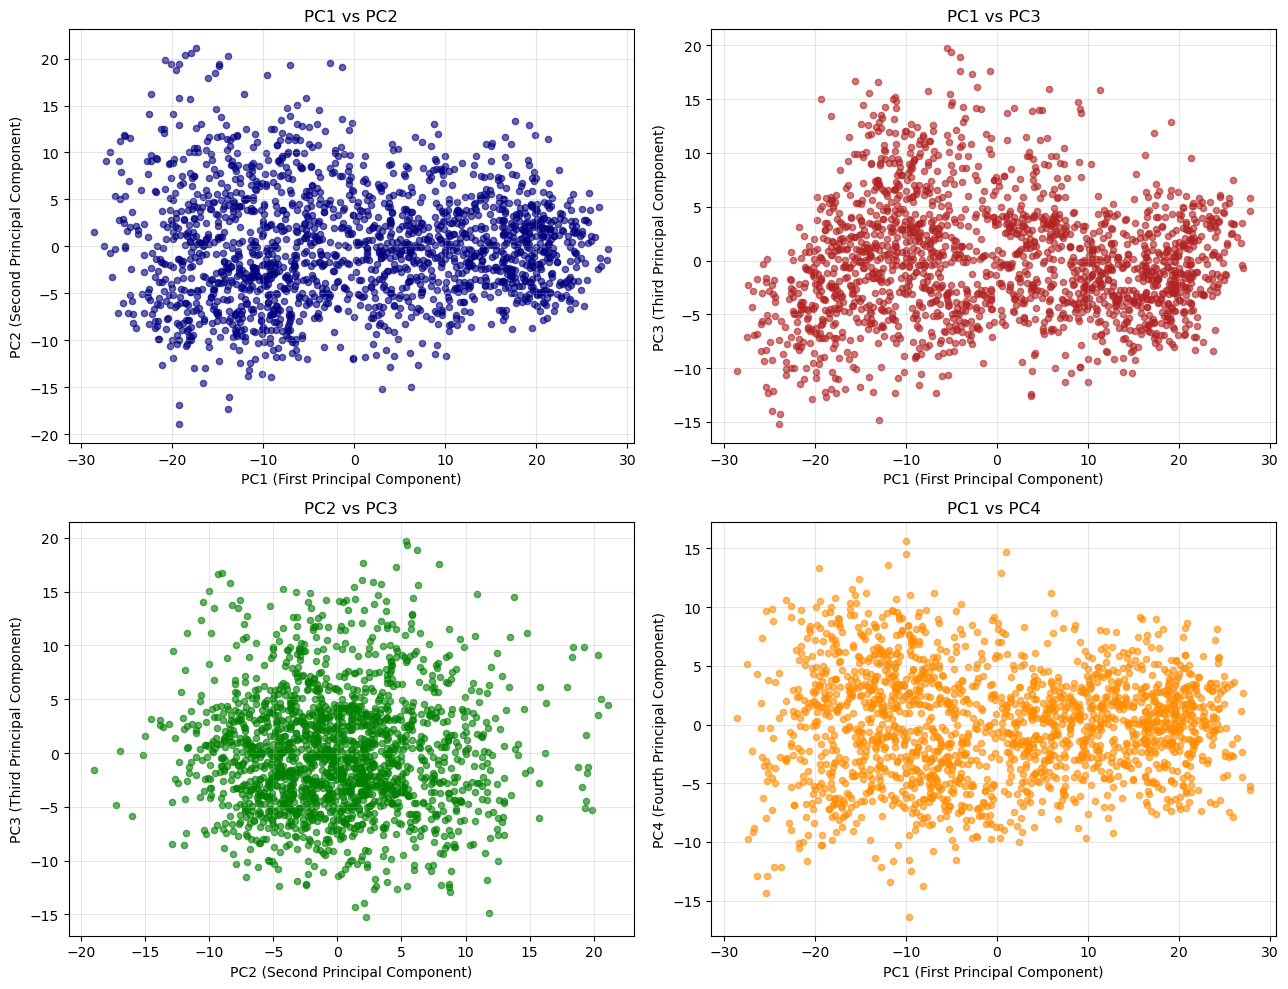

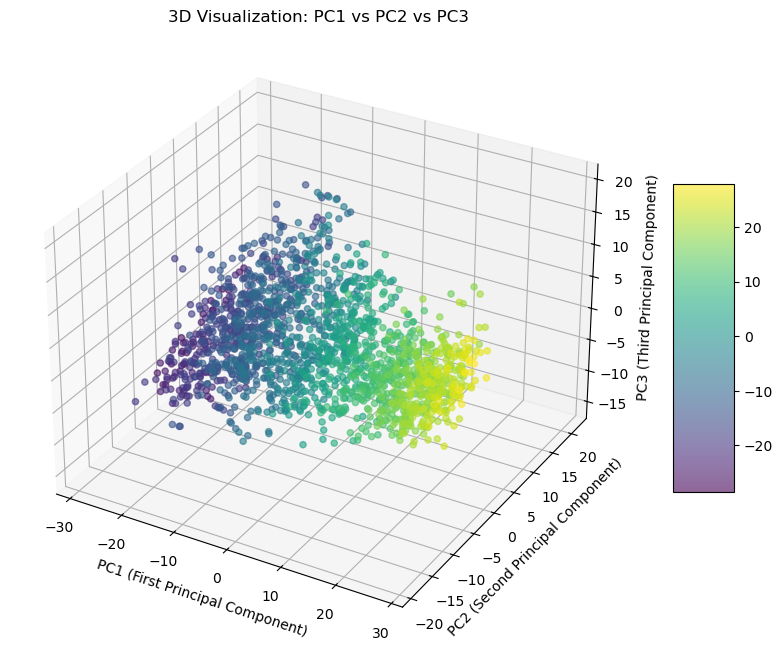

In [11]:
print("VISUALIZATION OF PRINCIPAL COMPONENTS")

# 1. SCATTER PLOT 2D: PC1 vs PC2
scatter_plot_2d(X_pca)

# 2. SCATTER PLOT 3D: PC1 vs PC2 vs PC3
scatter_plot_3d(X_pca)


<span style="color: skyblue;">Capire cosa rappresentano i puntini</span> --> La posizione del puntino è determinata dalle sue coordinate proiettate su due componenti principali.

**PC1 vs PC2**: Two distinct clusters are clearly visible, indicating good separation between different meteorological configurations. PC1 appears to capture a primary discriminant direction that effectively separates the data into distinct atmospheric patterns. This suggests that PC1 represents the most significant mode of variability in European weather patterns, potentially corresponding to major synoptic-scale phenomena.

**PC2 vs PC3 and PC1 vs PC3**: The separation between clusters is less pronounced in these projections. PC3 captures more dispersed variance, suggesting it represents secondary meteorological patterns that are more spatially or temporally distributed. The weaker clustering indicates that PC3 may correspond to regional-scale variations or transitional weather states.

**PC1 vs PC4**: PC4 shows minimal evident structure and appears to contain less discriminative information. This component likely represents either background noise or minor meteorological variations that contribute less to the overall atmospheric configuration patterns.


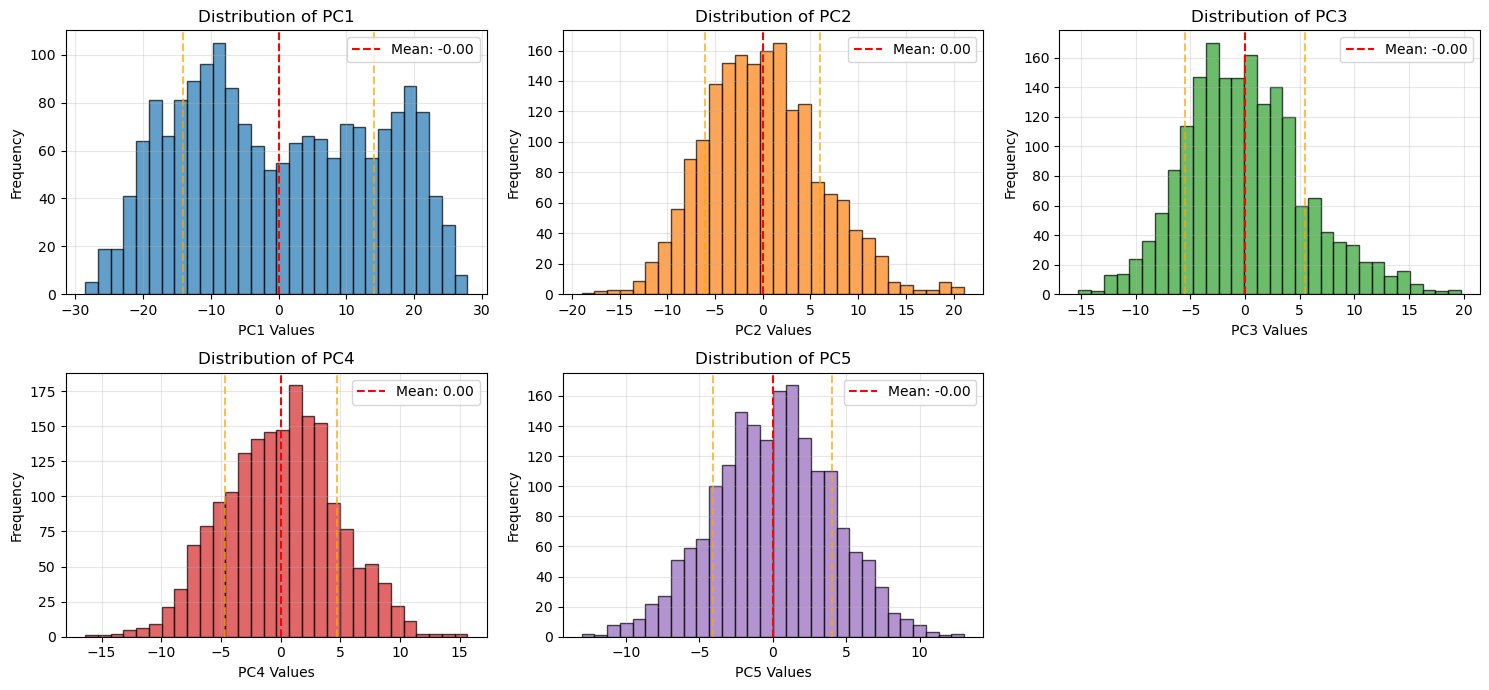


   • SUMMARY STATISTICS FOR FIRST 5 COMPONENTS:
   • PC1: Mean=-0.000, Std=14.086, Min=-28.558, Max=27.864
   • PC2: Mean=0.000, Std=6.021, Min=-18.971, Max=21.115
   • PC3: Mean=-0.000, Std=5.528, Min=-15.231, Max=19.737
   • PC4: Mean=0.000, Std=4.695, Min=-16.390, Max=15.662
   • PC5: Mean=-0.000, Std=4.053, Min=-13.009, Max=13.021


In [12]:
# 3. HISTOGRAMS of first 5 components
fig, axes = plt.subplots(2, 3, figsize=(15, 7))
axes = axes.flatten()

for i in range(5):
    axes[i].hist(X_pca[:, i], bins=30, alpha=0.7, color=f'C{i}', edgecolor='black')
    axes[i].set_xlabel(f'PC{i+1} Values')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Distribution of PC{i+1}')
    axes[i].grid(True, alpha=0.3)
    
    # Add statistics
    mean_val = X_pca[:, i].mean()
    std_val = X_pca[:, i].std()
    axes[i].axvline(mean_val, color='red', linestyle='--', 
                   label=f'Mean: {mean_val:.2f}')
    axes[i].axvline(mean_val + std_val, color='orange', linestyle='--', alpha=0.7)
    axes[i].axvline(mean_val - std_val, color='orange', linestyle='--', alpha=0.7)
    axes[i].legend()

axes[5].remove()

plt.tight_layout()
plt.show()

# 4. SUMMARY STATISTICS
print("\n   • SUMMARY STATISTICS FOR FIRST 5 COMPONENTS:")
for i in range(5):
    pc_data = X_pca[:, i]
    print(f"   • PC{i+1}: Mean={pc_data.mean():.3f}, Std={pc_data.std():.3f}, "
          f"Min={pc_data.min():.3f}, Max={pc_data.max():.3f}")


**PC2, PC3, PC4, PC5** → Normal distributions centered at 0, as expected in normalized PCA. These components show typical Gaussian-like behavior with:
- Mean ≈ 0 
- Symmetric, bell-shaped distributions
- Standard deviations around 1, indicating proper normalization

**PC1** → **Bimodal distribution**   
The bimodal pattern indicates that PC1 effectively separates the data into **two distinct groups**. This suggests:
- Two dominant meteorological regimes in European weather patterns
- PC1 captures the primary mode of atmospheric variability that distinguishes between these regimes
- Strong evidence for natural clustering structure in the data

In [13]:
sf = shp.Reader("world/world-administrative-boundaries.shp")

VISUALIZZAZIONE DELLA PRIME COMPONENTI PRINCIPALI


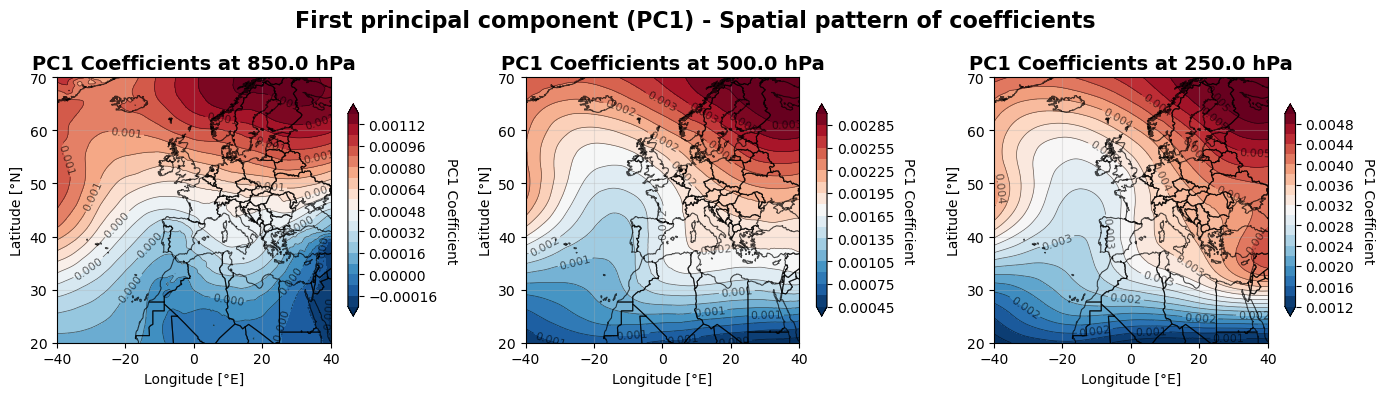

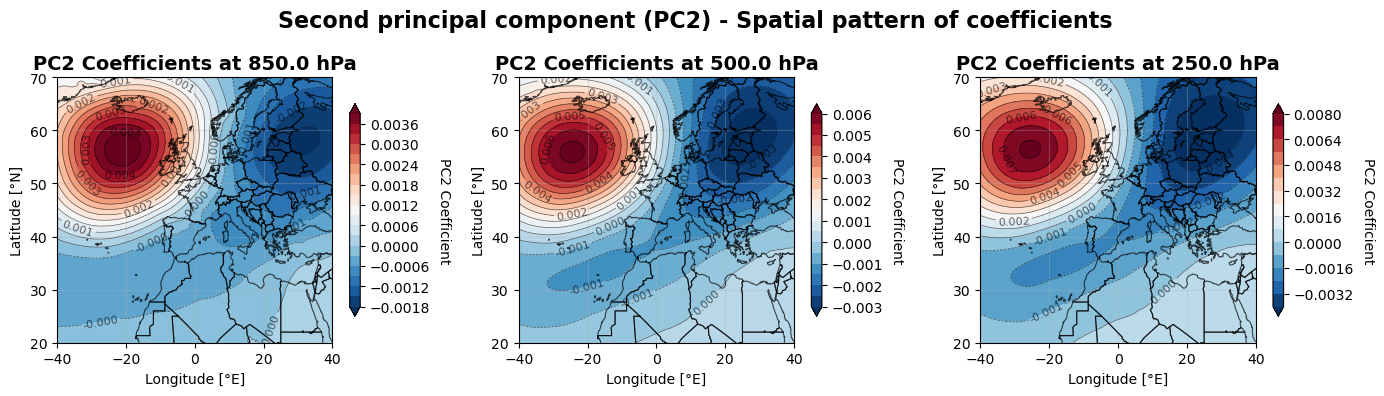

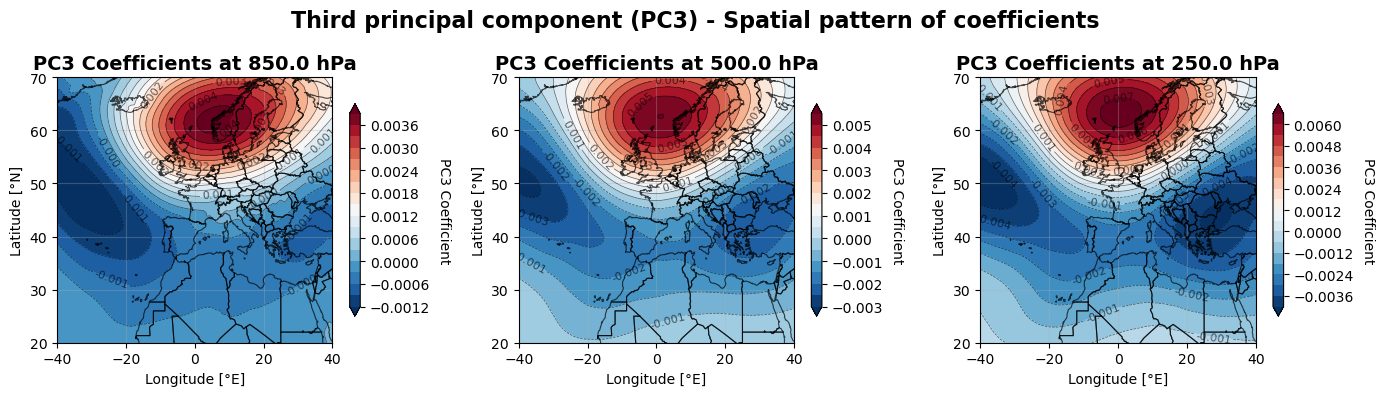


   • STATISTICHE COMPARATIVE PER LIVELLO DI PRESSIONE:
   • Pressure   PC1 Min      PC1 Max      PC2 Min      PC2 Max      PC3 Min      PC3 Max     
   • ------------------------------------------------------------------------------------
   • 850.0      -0.000273    0.001246     -0.001859    0.004138     -0.001457    0.004020    
   • 500.0      0.000369     0.003115     -0.003314    0.006164     -0.003116    0.005506    
   • 250.0      0.001035     0.005185     -0.004708    0.008148     -0.004695    0.006929    


In [14]:
print("VISUALIZZAZIONE DELLA PRIME COMPONENTI PRINCIPALI")

components_to_plot = [
    (ipca.components_[0], "PC1", "First principal component (PC1)"),
    (ipca.components_[1], "PC2", "Second principal component (PC2)"),
    (ipca.components_[2], "PC3", "Third principal component (PC3)")
]

# Get dimensions from original dataset (ds), not from X_pca which is a numpy array
n_lat = ds.dims['latitude'] if 'latitude' in ds.dims else len(ds.latitude)
n_lon = ds.dims['longitude'] if 'longitude' in ds.dims else len(ds.longitude)
n_pressure = ds.dims['isobaricInhPa'] if 'isobaricInhPa' in ds.dims else len(ds.isobaricInhPa)

lats = ds.latitude.values
lons = ds.longitude.values
pressure_levels = ds.isobaricInhPa.values.tolist()


visualization_pca_coefficient(components_to_plot, pressure_levels, lats, lons, n_pressure, n_lat, n_lon, sf=sf)

# Statistiche comparative per tutte le componenti
print(f"\n   • STATISTICHE COMPARATIVE PER LIVELLO DI PRESSIONE:")
print(f"   • {'Pressure':<10} {'PC1 Min':<12} {'PC1 Max':<12} {'PC2 Min':<12} {'PC2 Max':<12} {'PC3 Min':<12} {'PC3 Max':<12}")
print(f"   • {'-'*84}")

# Ricostruisci tutte le componenti per le statistiche
pc1_reshaped = components_to_plot[0][0].reshape(n_pressure, n_lat, n_lon)
pc2_reshaped = components_to_plot[1][0].reshape(n_pressure, n_lat, n_lon)
pc3_reshaped = components_to_plot[2][0].reshape(n_pressure, n_lat, n_lon)

for i, pressure in enumerate(pressure_levels):
    pc1_level = pc1_reshaped[i, :, :]
    pc2_level = pc2_reshaped[i, :, :]
    pc3_level = pc3_reshaped[i, :, :]
    
    print(f"   • {pressure:<10} {pc1_level.min():<12.6f} {pc1_level.max():<12.6f} "
          f"{pc2_level.min():<12.6f} {pc2_level.max():<12.6f} "
          f"{pc3_level.min():<12.6f} {pc3_level.max():<12.6f}")

The previous plots show the spatial distribution of the PCA coefficients (the values in the array ipca.components_). These coefficients are abstract and cannot be interpreted physically; they represent the mathematical “weight” that each geographical point has in the principal component. Red indicates a positive coefficient, while blue indicates a negative one. The color intensity reflects how strongly that point contributes to the principal component. In other words, the plots highlight where the component is geographically “more active.”

To understand what each principal component actually represents, we then plot the real atmospheric pattern associated with each principal component.

VISUALIZZAZIONE DEI PATTERN ATMOSFERICI REALI DELLE COMPONENTI PRINCIPALI

=== First principal component (PC1) ===
Deviazione standard PC1: 14.090
Range del pattern: ±508499.3m


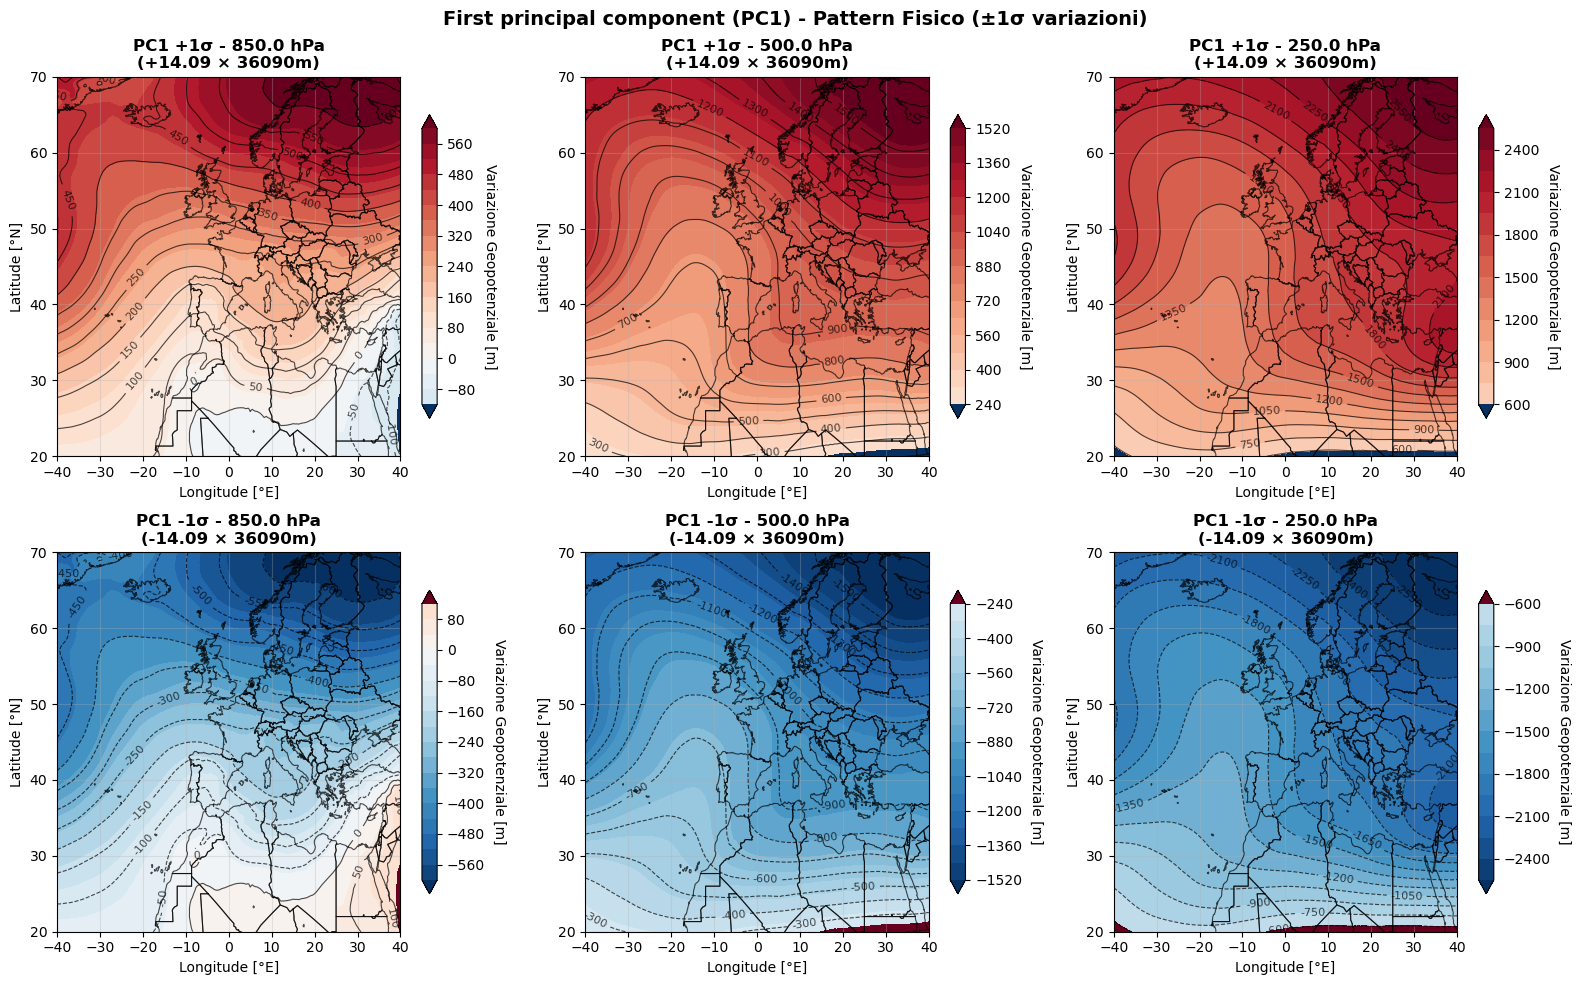

Statistiche pattern ricostruito per PC1:
  850.0 hPa:
    +1σ: range -139 to 633m
    -1σ: range -633 to 139m
    Ampiezza totale: 1267m
  500.0 hPa:
    +1σ: range 188 to 1584m
    -1σ: range -1584 to -188m
    Ampiezza totale: 3168m
  250.0 hPa:
    +1σ: range 527 to 2637m
    -1σ: range -2637 to -527m
    Ampiezza totale: 5274m

=== Second principal component (PC2) ===
Deviazione standard PC2: 6.023
Range del pattern: ±217367.0m


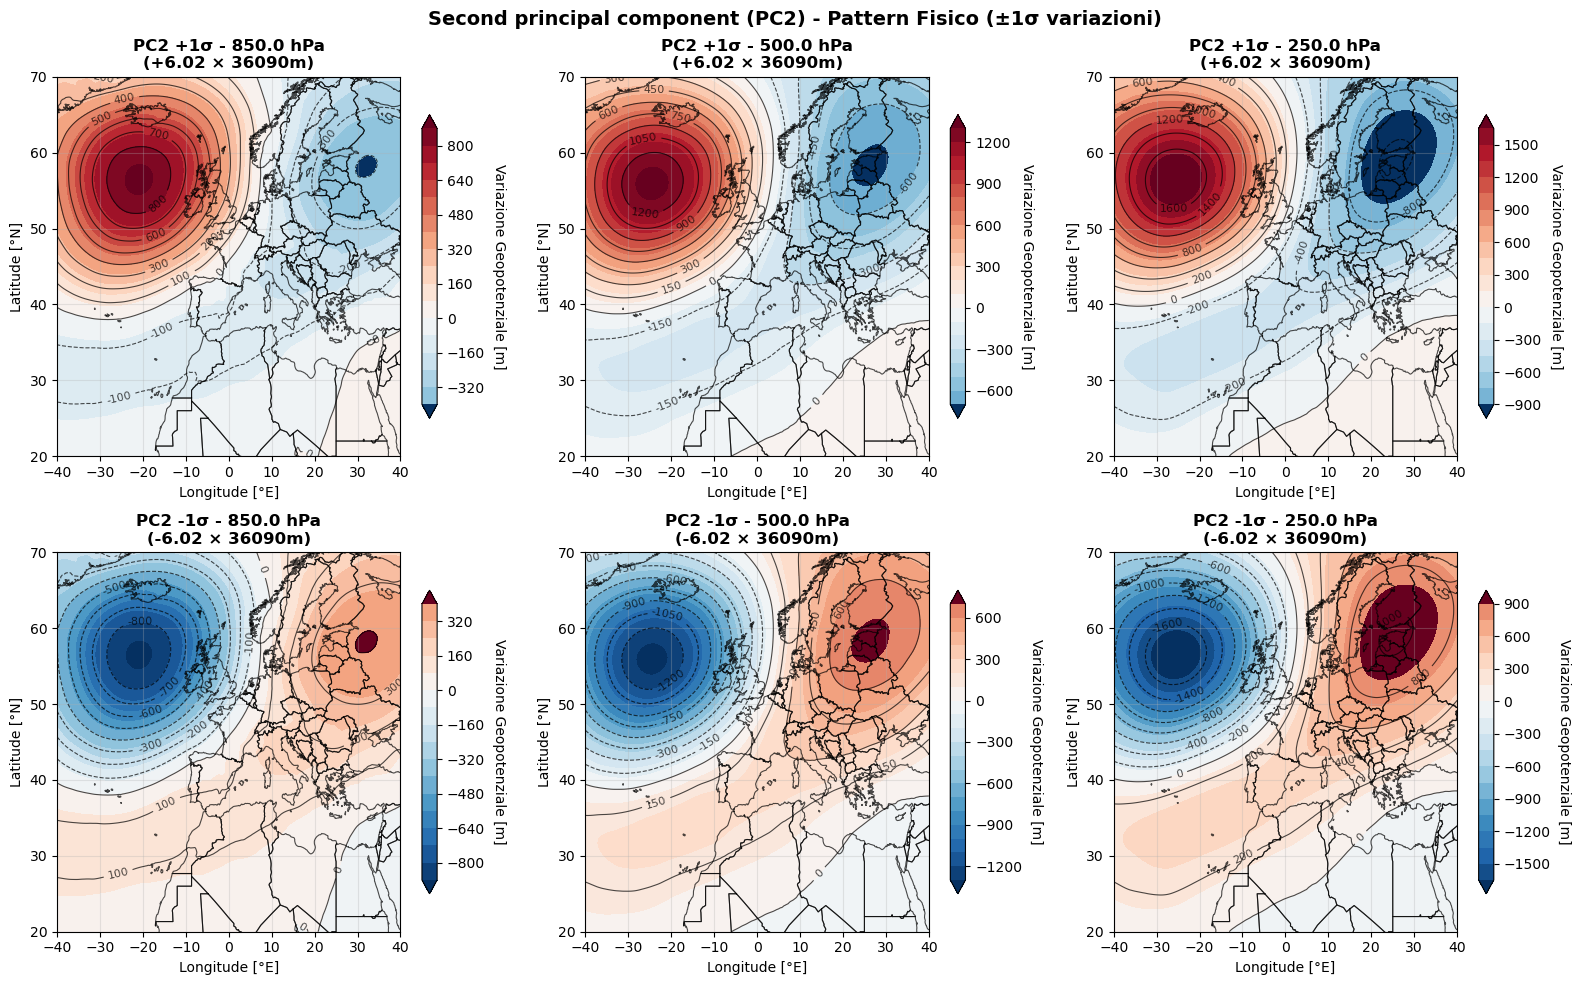

Statistiche pattern ricostruito per PC2:
  850.0 hPa:
    +1σ: range -404 to 899m
    -1σ: range -899 to 404m
    Ampiezza totale: 1799m
  500.0 hPa:
    +1σ: range -720 to 1340m
    -1σ: range -1340 to 720m
    Ampiezza totale: 2680m
  250.0 hPa:
    +1σ: range -1023 to 1771m
    -1σ: range -1771 to 1023m
    Ampiezza totale: 3542m

=== Third principal component (PC3) ===
Deviazione standard PC3: 5.529
Range del pattern: ±199549.4m


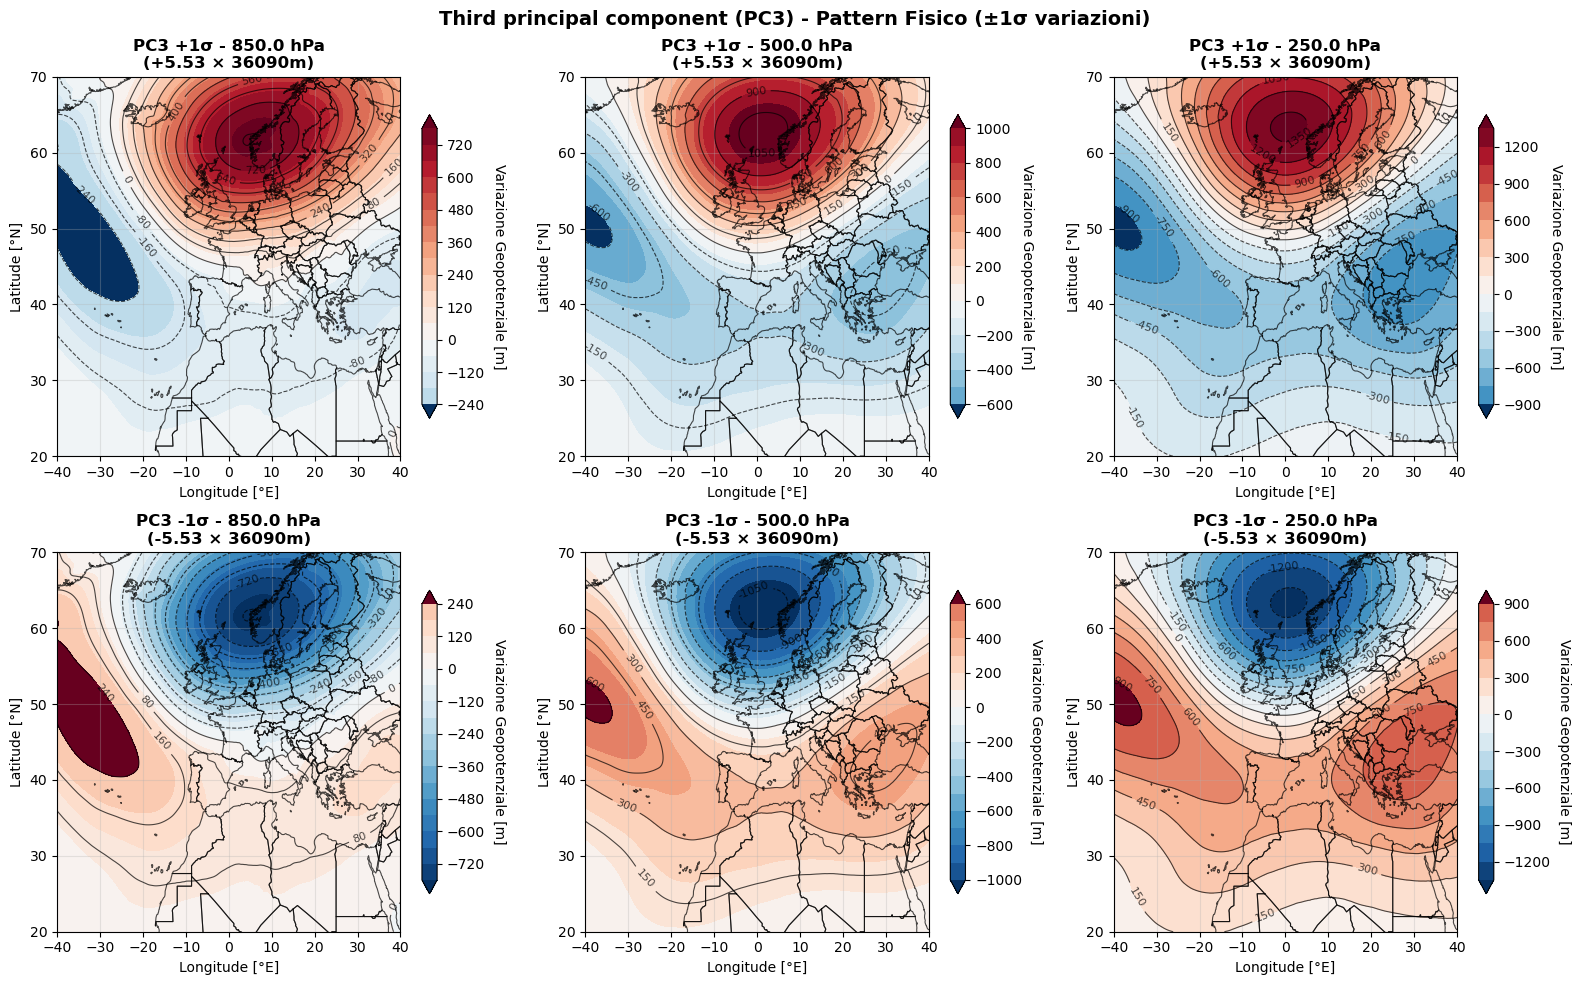

Statistiche pattern ricostruito per PC3:
  850.0 hPa:
    +1σ: range -291 to 802m
    -1σ: range -802 to 291m
    Ampiezza totale: 1604m
  500.0 hPa:
    +1σ: range -622 to 1099m
    -1σ: range -1099 to 622m
    Ampiezza totale: 2197m
  250.0 hPa:
    +1σ: range -937 to 1383m
    -1σ: range -1383 to 937m
    Ampiezza totale: 2766m


In [15]:
print("VISUALIZZAZIONE DEI PATTERN ATMOSFERICI REALI DELLE COMPONENTI PRINCIPALI")

def visualization_pca_real(components_to_plot, pressure_levels, lats, lons, n_pressure, n_lat, n_lon, sf=None):

    for pc_idx, (pc_coefficients, pc_name, pc_title) in enumerate(components_to_plot):
    
        print(f"\n=== {pc_title} ===")
    
        # Ricostruire il pattern fisico della componente principale
        # Pattern = coefficienti_PC × deviazione_standard_PC × scala_globale
        pc_std = np.sqrt(ipca.explained_variance_[pc_idx])
    
        # Ricostruiamo il pattern per +1σ e -1σ della componente
        pattern_positive = pc_coefficients * pc_std * global_std  # +1 deviazione standard
        pattern_negative = pc_coefficients * (-pc_std) * global_std  # -1 deviazione standard
    
        print(f"Deviazione standard {pc_name}: {pc_std:.3f}")
        print(f"Range del pattern: ±{pc_std * global_std:.1f}m")
    
        # Reshape per la visualizzazione spaziale
        pattern_pos_reshaped = pattern_positive.reshape(n_pressure, n_lat, n_lon)
        pattern_neg_reshaped = pattern_negative.reshape(n_pressure, n_lat, n_lon)
    
        # Subplots per confrontare +1σ e -1σ
        fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    
        # Plot per +1 deviazione standard (pattern positivo)
        for i, pressure in enumerate(pressure_levels):
            ax = axes[0, i]
            data_positive = pattern_pos_reshaped[i, :, :]
        
            lon_grid, lat_grid = np.meshgrid(lons, lats)
        
            # Usa una scala simmetrica per entrambi i plot
            vmax = max(abs(data_positive.min()), abs(data_positive.max()))
            vmin = -vmax
        
            # Contour lines
            contour_lines = ax.contour(lon_grid, lat_grid, data_positive, 
                                  levels=15, linewidths=0.8, colors='black', alpha=0.7)
        
            # Contour filled con scala divergente
            contour_filled = ax.contourf(lon_grid, lat_grid, data_positive, 
                                    levels=20, cmap="RdBu_r", vmin=vmin, vmax=vmax, extend='both')
        
            # Labels on contour lines
            ax.clabel(contour_lines, inline=True, fontsize=8, fmt='%.0f')
        
            # Europe shape
            if sf is not None:
                add_country_boundaries(ax, sf)
        
            ax.set_title(f'{pc_name} +1σ - {pressure} hPa\n(+{pc_std:.2f} × {global_std:.0f}m)', 
                    fontsize=12, fontweight='bold')
            ax.set_xlabel('Longitude [°E]')
            ax.set_ylabel('Latitude [°N]')
            ax.set_xlim([lons.min(), lons.max()])
            ax.set_ylim([lats.min(), lats.max()])
            ax.grid(True, alpha=0.3)
        
            cbar = plt.colorbar(contour_filled, ax=ax, shrink=0.8)
            cbar.set_label('Variazione Geopotenziale [m]', rotation=270, labelpad=15)
    
        # Plot per -1 deviazione standard (pattern negativo)
        for i, pressure in enumerate(pressure_levels):
            ax = axes[1, i]
            data_negative = pattern_neg_reshaped[i, :, :]
        
            lon_grid, lat_grid = np.meshgrid(lons, lats)
        
            # Usa la stessa scala simmetrica
            vmax = max(abs(data_negative.min()), abs(data_negative.max()))
            vmin = -vmax
        
            # Contour lines
            contour_lines = ax.contour(lon_grid, lat_grid, data_negative, 
                                  levels=15, linewidths=0.8, colors='black', alpha=0.7)
        
            # Contour filled con scala divergente
            contour_filled = ax.contourf(lon_grid, lat_grid, data_negative, 
                                    levels=20, cmap="RdBu_r", vmin=vmin, vmax=vmax, extend='both')
        
            # Labels on contour lines
            ax.clabel(contour_lines, inline=True, fontsize=8, fmt='%.0f')
        
            if sf is not None:
                add_country_boundaries(ax, sf)
        
            ax.set_title(f'{pc_name} -1σ - {pressure} hPa\n(-{pc_std:.2f} × {global_std:.0f}m)', 
                    fontsize=12, fontweight='bold')
            ax.set_xlabel('Longitude [°E]')
            ax.set_ylabel('Latitude [°N]')
            ax.set_xlim([lons.min(), lons.max()])
            ax.set_ylim([lats.min(), lats.max()])
            ax.grid(True, alpha=0.3)
        
            cbar = plt.colorbar(contour_filled, ax=ax, shrink=0.8)
            cbar.set_label('Variazione Geopotenziale [m]', rotation=270, labelpad=15)

        # Title generale
        fig.suptitle(f'{pc_title} - Pattern Fisico (±1σ variazioni)',
                 fontsize=14, fontweight='bold', y=0.98)
    
        plt.tight_layout()
        plt.show()
    
        # Stampa statistiche sui pattern ricostruiti
        print(f"Statistiche pattern ricostruito per {pc_name}:")
        for i, pressure in enumerate(pressure_levels):
            pos_pattern = pattern_pos_reshaped[i, :, :]
            neg_pattern = pattern_neg_reshaped[i, :, :]
        
            print(f"  {pressure} hPa:")
            print(f"    +1σ: range {pos_pattern.min():.0f} to {pos_pattern.max():.0f}m")
            print(f"    -1σ: range {neg_pattern.min():.0f} to {neg_pattern.max():.0f}m")
            print(f"    Ampiezza totale: {pos_pattern.max() - neg_pattern.min():.0f}m")

visualization_pca_real(components_to_plot, pressure_levels, lats, lons, n_pressure, n_lat, n_lon, sf=sf)

Mostra le vere variazioni fisiche in metri di geopotenziale  
Risultato del calcolo: coefficienti × deviazione_standard × scala_globale  
Rappresenta quanto cambia realmente il geopotenziale quando quella PC varia di ±1σ  
Mostra quanto si alzano/abbassano i livelli di pressione  
Rappresenta i pattern atmosferici reali che quella PC cattura   
- Variazioni reali: "quando PC1 aumenta di 1σ, il geopotenziale aumenta di X metri qui"
- Intensità meteorologica: quanto sono forti i cambiamenti di pressione  
_ _ _ - - _ _ _ 

**Prima Componente Principale (PC1)**  
Pattern identificato: GRADIENTE NORD-SUD EUROPEO

PC1 Positivo (MAX): Configurazione con alta pressione al sud e bassa al nord

Anticiclone prominente sull'Europa meridionale/Mediterraneo  
Depressione ciclonica sulla Scandinavia  
Forte gradiente barico nord-sud (differenza di 1214m a 850 hPa)  
PC1 Negativo (MIN): Configurazione opposta

Alta pressione estesa verso nord  
Pattern più omogeneo su tutta l'Europa  
Rappresenta condizioni più stabili e uniformi

**Seconda Componente Principale (PC2)**  
Pattern identificato: GRADIENTE OVEST-EST

PC2 Positivo (MAX): Alta pressione a ovest, bassa a est

Anticiclone atlantico che si estende verso l'Europa occidentale  
Valori di geopotenziale più bassi verso est  
Pattern tipico dell'influenza atlantica  
PC2 Negativo (MIN): Inversione del gradiente ovest-est

Configurazione con influenza continentale più marcata  
Differenze minori tra livelli (solo 345m a 500 hPa)  

**Terza Componente Principale (PC3)**  
Pattern identificato: PATTERN DIPOLARI COMPLESSI    

PC3 Positivo (MAX): Strutture dipolari ben definite

Alternanza di centri di alta e bassa pressione  
Pattern più localizzati e complessi  
PC3 Negativo (MIN): Configurazioni più zonali  

Pattern più estesi longitudinalmente  
Strutture meno localizzate  
🔍 OSSERVAZIONI CHIAVE  
Coerenza Verticale: I pattern sono coerenti attraverso tutti i livelli atmosferici (850, 500, 250 hPa),   indicando strutture barotropiche profonde

Intensità del Segnale: PC1 mostra le differenze più marcate (6353m a 250 hPa), confermando che è il modo dominante di variabilità

Significato Meteorologico:

PC1 rappresenta l'oscillazione principale dell'Europa tra configurazioni meridionali e settentrionali  
PC2 cattura l'influenza atlantica vs continentale  
PC3 descrive pattern più complessi e localizzati

_ _ _ - - _ _ _ - - _ _ _ 

We chose **not to weight the principal components** by their explained variance for the clustering analysis. While PC1 dominates with 54.2% of the variance compared to PC2 (9.9%) and PC3 (8.3%), weighting schemes significantly compromise the clustering quality. Linear weighting causes PC1 to dominate 97.5% of the clustering influence, effectively reducing the problem to a unidimensional analysis and eliminating the contribution of meteorologically meaningful secondary patterns.   
Even moderate $\sqrt{variance}$ weighting biases the clustering toward PC1 (84% influence) while drastically reducing the impact of PC2 and PC3. In contrast, unweighted components maintain a balanced contribution, preserving the multidimensional structure of atmospheric variability.   
This approach is particularly important for meteorological applications where secondary components often capture crucial regional patterns, seasonal variations, or synoptic-scale features that, despite explaining less variance globally, are essential for identifying distinct weather regimes. 

## 3 Clusterization /o classification?


Now that we have analyzed the data, we have performed Principal Component Analysis (PCA) in order to reduce the dimensionality of the dataset and to highlight the most relevant features and components.
The next step is to implement an algorithm to cluster the data. The first method we will apply is the k-means algorithm.

_pg 28 articolo 2-the classification of atmosphere .._

### 3.1 K-means Implementation

The k-means algorithm allows us to divide the dataset into k groups (k is given, and we will perform an analysis later to determine the best value, as this is a key point). The association of each element in the dataset to a specific group is based on its attributes.

_it is a top-down procedure_

The goal of the algorithm is to minimize the total variance between different groups. Each group is identified through a centroid, note that they are not, in general, points from the dataset although they live in the same space.

Iteratively, the algorithm creates k partitions and assigns the incoming points to the groups. Then, it computes the centroids of each cluster and reassigns each point to the nearest centroid, using the Euclidean distance or another metric. The new centroids are then computed again, and the process continues until the method converges.

<span style="color: orange;">The MiniBatchKMeans is a variant of the KMeans algorithm which uses mini-batches to reduce the computation time, while still attempting to optimise the same objective function. </span>

_per me_  
**INIZIALIZZAZIONE**: k-means++’ : selects initial cluster centroids using sampling based on an empirical probability distribution of the points’ contribution to the overall inertia. This technique speeds up convergence. The algorithm implemented is “greedy k-means++”. It differs from the vanilla k-means++ by making several trials at each sampling step and choosing the best centroid among them.  
‘random’: choose n_clusters observations (rows) at random from data for the initial centroids.
If an array is passed, it should be of shape (n_clusters, n_features) and gives the initial centers.  
If a callable is passed, it should take arguments X, n_clusters and a random state and return an initialization.  

**N_INIT** : Number of times the k-means algorithm is run with different centroid seeds. The final results is the best output of n_init consecutive runs in terms of inertia. Several runs are recommended for sparse high-dimensional problems

-  -  

Perché k-means++ è preferibile:

    Sceglie il primo centro a caso, poi ogni centro successivo è scelto con probabilità proporzionale alla distanza al quadrato dal centro più vicino → evita centri troppo vicini fra loro.  
    Riduce la probabilità di convergere a soluzioni pessime.  
    Richiede poco overhead computazionale rispetto a una scelta casuale pura.

_fit(X, y=None, sample_weight=None)_ --> computes k-means clustering. ----  _returns:_ Fitted estimator.

_fit_predict(X, y=None, sample_weight=None)_ --> Compute cluster centers and predict cluster index for each sample. --- _returns:_ Index of the cluster each sample belongs to.

_predict(X)_ --> Predict the closest cluster each sample in X belongs to. ---  _returns:_ Index of the cluster each sample belongs to.

_transform(X)_ --> Transform X to a cluster-distance space. In the new space, each dimension is the distance to the cluster centers. Note that even if X is sparse, the array returned by transform will typically be dense --- _returns:_ X transformed in the new space.

In [16]:

K_range = range(2, 15)  

def kmeans(X_pca,K_range,n_init=20):
    inertia = []
    silhouette_scores = []

    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=n_init)
        labels = kmeans.fit_predict(X_pca)
        inertia.append(kmeans.inertia_)

    
    # Calculate silhouette score
    score = silhouette_score(X_pca, labels)
    silhouette_scores.append(score)

# Save results for later analysis
    results = {
        "K_range": list(K_range),
        "inertia": inertia,
        "silhouette_scores": silhouette_scores
    }
    return results

results = kmeans(X_pca, n_init=20, K_range=K_range)

#### 3.1.1 Evaluation of the best number of clusters (k)

_PER SELEZIONARE IL NUMERO DI CLUSTERS_ -->  https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py  

. curva a gomito  
. pg.519 - BookAdvanced

_ _ _ - - _ _ _ 

Idea intuitiva: se ci sono davvero K* gruppi naturali, aumentando K da 1 fino a K* ogni incremento separa veri gruppi e provoca una grande riduzione di WKWK​. Per K>K* ogni ulteriore cluster tende a spezzare gruppi già omogenei → riduzioni piccole. Quindi il grafico K vs W_k_ha una curva decrescente con un kink (gomito) approssimativamente a K*

WK(inertia)​ è la somma delle varianze interne (o somme di distanze quadratiche) di tutti i cluster.

WK​ è proprio la misura totale di “quanto sono vicini” i punti ai loro centri di cluster.

    Se i punti sono molto vicini al centro → W_k​ sarà piccolo (buon clustering).

    Se i punti sono sparsi → W_k_sarà grande.

Quando aumenti K (cioè il numero di cluster), i punti possono essere raggruppati in insiemi più piccoli e più vicini ai loro centri → WKWK​ tende sempre a diminuire

_ _ _ - - _ _ _ - - _ _ _




##### ELBOW _ _ _ - - _ _ _

The elbow is the most far away point from the line that links the first to the last point --> È il punto di massima curvatura geometrica

inerzia: Inerzia = Σ(i=1 to k) Σ(x∈Ci) ||x - μi||²  
k = numero di cluster  
Ci = cluster i-esimo  
x = punto dati  
μi = centroide del cluster i  
||x - μi||² = distanza euclidea al quadrato  

Inerzia = somma delle distanze al quadrato di tutti i punti dai loro centroidi  
Alta inerzia = punti sparsi, cluster "larghi" e poco compatti  
Bassa inerzia = punti vicini ai centroidi, cluster compatti  

Se l'inzerzia cala: I cluster diventano più compatti internamente. I punti sono più vicini ai loro centroidi, La variabilità interna dei cluster diminuisce, Il clustering è più preciso.

##### PERCENTAGE REDUCTION   _ _ _ - - _ _ _
Riduzione% = (Inerzia[k-1] - Inerzia[k]) / Inerzia[k-1] × 100  
mi dice: Quanto beneficio ottengo aggiungendo un cluster in più e l'efficacia marginale di ogni nuovo cluster

Treshold --> 5% (<span style="color: skyblue;">va diminuito? HO MESSO 3%) </span> evito sovra-clusterizzazione- Differenze del 5-7% possono catturare fenomeni meteorologici rilevanti (NAO phases, blocking patterns, seasonal transitions)

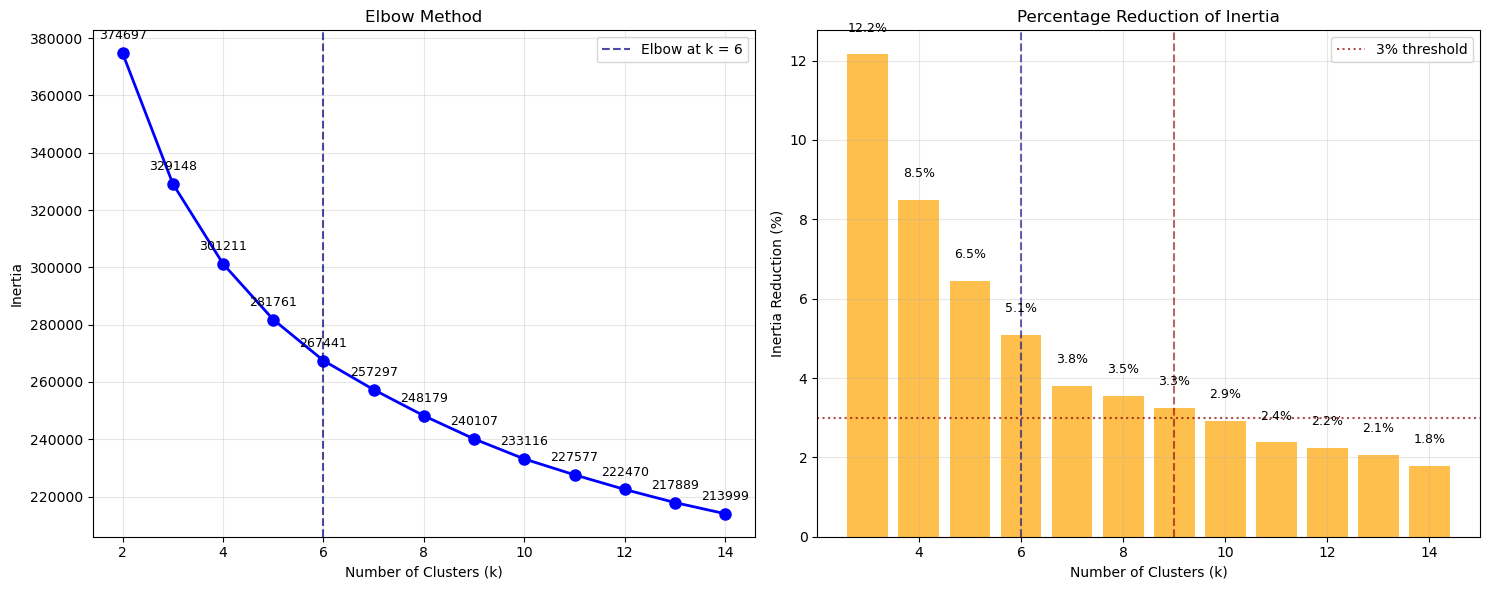

Elbow method suggests k = 6
With 3% threshold, valid range: k ≤ 9


In [24]:
# ELBOW METHOD WITH PERCENTAGE REDUCTION

def elbow_analysis(results_dict):
    """
    Analizza la curva dell'elbow method e calcola le riduzioni percentuali
    """
    K_range = results_dict["K_range"]
    inertias = results_dict["inertia"]
    
    # Calcolo riduzione percentuale
    reduction_pct = []
    for i in range(1, len(inertias)):
        reduction = (inertias[i-1] - inertias[i]) / inertias[i-1] * 100
        reduction_pct.append(reduction)
    
    # Trova il gomito usando il metodo della distanza massima
    def find_elbow_point(x, y):
        # Linea dal primo all'ultimo punto
        first_point = np.array([x[0], y[0]])
        last_point = np.array([x[-1], y[-1]])
        
        # Calcola distanze di ogni punto dalla linea
        distances = []
        for i in range(len(x)):
            point = np.array([x[i], y[i]])
            distance = np.abs(np.cross(last_point - first_point, first_point - point)) / np.linalg.norm(last_point - first_point)
            distances.append(distance)
        
        # Restituisce k con distanza massima
        max_idx = np.argmax(distances)
        return x[max_idx]
    
    k_elbow = find_elbow_point(K_range, inertias)
    
    # Grafici
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Grafico elbow
    ax1.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
    ax1.axvline(k_elbow, color='navy', linestyle='--', alpha=0.7, 
                label=f'Elbow at k = {k_elbow}')
    ax1.set_xlabel('Number of Clusters (k)')
    ax1.set_ylabel('Inertia')
    ax1.set_title('Elbow Method')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Valori sui punti
    for k, inertia in zip(K_range, inertias):
        ax1.annotate(f'{inertia:.0f}', (k, inertia), 
                    textcoords="offset points", xytext=(0,10), 
                    ha='center', fontsize=9)
    
    # Grafico riduzione percentuale
    ax2.bar(K_range[1:], reduction_pct, alpha=0.7, color='orange')
    ax2.axhline(3, color='darkred', linestyle=':', alpha=0.7, 
                label='3% threshold')
    ax2.axvline(k_elbow, color='navy', linestyle='--', alpha=0.6)
    ax2.axvline(9, color='darkred', linestyle='--', alpha=0.6)
    ax2.set_xlabel('Number of Clusters (k)')
    ax2.set_ylabel('Inertia Reduction (%)')
    ax2.set_title('Percentage Reduction of Inertia')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Valori sulle barre
    for k, reduction in zip(K_range[1:], reduction_pct):
        ax2.text(k, reduction + 0.5, f'{reduction:.1f}%', 
                ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    return k_elbow, reduction_pct

# Esegui analisi elbow
k_elbow, reductions = elbow_analysis(results)
print(f"Elbow method suggests k = {k_elbow}")
print(f"With 3% threshold, valid range: k ≤ 9")

The approach used by the elbow method is a geometric one, and it automatically detects the best number of clusters(k) by finding the point with the maximum distance from the line that links the first and the last point of the inertia curve. The result of the elbow method for our metereological dataset is k= 6. However, the insertia reduction curve apperas relatively smooth, because of the fact that atmospheric data contains weather patterns that transist gradually rather than with discontinuities. Applying a percentage reduction treshold provides more information: with a 10% treshold, k= 3-4 wuold be optimal; with a 5% treshold, k = 5-6, and with a 3% treshold teh range extends to k= 7-9. The smoothness of the curve shows us that the geometric elbow point remains stable regardless of the percentage treshold chosen.   
For our purpose the range k= 7-9 is a reasonable ecploration space, where each additional cluster captures gradually more detailed atmospheric patterns while maintaining statistical significance above the 3% improvement treshold.

_ _ _ - - _ _ _

The Gap Statistic compares the within-cluster dispersion of your real data against what you would expect from random uniform data. If your data has natural clusters, the real data should be much more "clustered" (lower inertia) than random data.

Gap(k) = E[log(W_k^ref)] - log(W_k^real)
W_k^real = Inertia of your actual meteorological data with k clusters  
W_k^ref = Expected inertia of random uniform data with k clusters  
E[...] = Expected value (average over multiple random datasets)  

USING PRECOMPUTED K-MEANS RESULTS


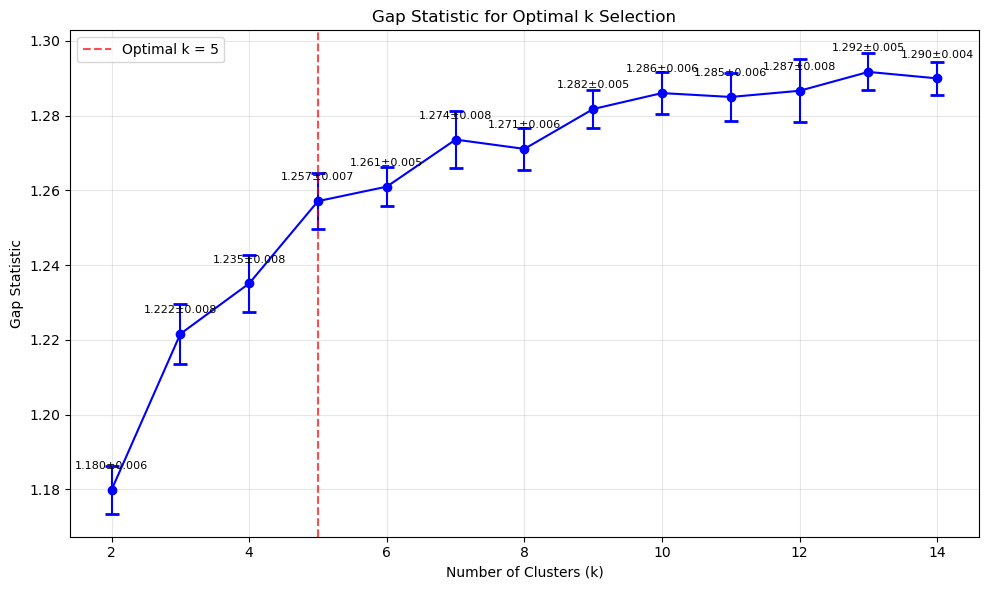

Gap Statistic suggests optimal k = 5


In [ ]:
# GAP STATISTIC ANALYSIS

def gap_statistic_analysis_optimized(X_data, K_range, precomputed_inertias=None, n_refs=20, random_state=42):
    """
    Compute Gap Statistic to determine optimal number of clusters
    """
    np.random.seed(random_state)
    
    # Get data boundaries for random reference datasets
    data_min = X_data.min(axis=0)
    data_max = X_data.max(axis=0)
    
    gaps = []
    standard_errors = []
    
    for i, k in enumerate(K_range):
        
        actual_inertia = precomputed_inertias[i]
        # Generate reference datasets and compute their inertias
        reference_inertias = []
        for ref in range(n_refs):
            # Create uniform random data with same bounds as original
            X_random = np.random.uniform(data_min, data_max, size=X_data.shape)
            
            # Fit K-means on random data
            kmeans_random = KMeans(n_clusters=k, random_state=ref, n_init=10)
            kmeans_random.fit(X_random)
            reference_inertias.append(kmeans_random.inertia_)
        
        # Calculate Gap statistic and standard error
        log_actual = np.log(actual_inertia)
        log_references = np.log(reference_inertias)
        
        gap = np.mean(log_references) - log_actual
        s_k = np.sqrt(1 + 1.0/n_refs) * np.std(log_references, ddof=1)
        
        gaps.append(gap)
        standard_errors.append(s_k)
    
    # Find optimal k using Tibshirani rule: Gap(k) >= Gap(k+1) - s(k+1)
    k_optimal = K_range[0]
    for i in range(len(K_range) - 1):
        if gaps[i] >= gaps[i+1] - standard_errors[i+1]:
            k_optimal = K_range[i]
            break
    
    # Create plot
    plt.figure(figsize=(10, 6))
    plt.errorbar(K_range, gaps, yerr=standard_errors, fmt='o-', capsize=5, capthick=2, color='blue')
    plt.axvline(k_optimal, color='red', linestyle='--', alpha=0.7, 
                label=f'Optimal k = {k_optimal}')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Gap Statistic')
    plt.title('Gap Statistic for Optimal k Selection')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Add gap values on points
    for k, gap, s_k in zip(K_range, gaps, standard_errors):
        plt.annotate(f'{gap:.3f}±{s_k:.3f}', (k, gap), 
                    textcoords="offset points", xytext=(0,15), 
                    ha='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    return k_optimal, gaps, standard_errors

# Execute Gap Statistic analysis using precomputed results

k_gap_optimal, gap_values, error_values = gap_statistic_analysis_optimized(
    X_pca, 
    results["K_range"], 
    precomputed_inertias=results["inertia"], 
    n_refs=20
)
print(f"Gap Statistic suggests optimal k = {k_gap_optimal}")

k=2: Gap = 1.180 (low - too simple)  
k=3: Gap = 1.221 (rising)  
k=4: Gap = 1.235 (still rising)  
k=5: Gap = 1.257 (PEAK IDENTIFIED)  
k=6: Gap = 1.261 (slightly higher)  
k=7+: Gap plateaus around 1.27-1.29

Gap(5) = 1.257 ≥ Gap(6) - SE(6) = 1.261 - 0.005 = 1.256   
This is the first k where the Tibshirani rule is satisfie

B) Aiutano a scegliere il numero di cluster k

**Silhouette media vs k** → scegli k al picco (evitando soluzioni con cluster molto piccoli nel plot).
    Scikit-learn

**Elbow / riduzione % dell’inerzia** → cerca il gomito o quando la riduzione % scende sotto una soglia (es. 5–10%). Per automatizzare il gomito puoi usare la regola della massima distanza dalla secante (implementata sopra) o il metodo Kneedle.
    raghavan.usc.edu

**Gap Statistic** → scegli il più piccolo k tale che Gap(k) ≥ Gap(k+1) − s(k+1) (codice sopra).
    hastie.su.domains

(Opzionale) **Stabilità**: ripeti k-means su bootstrap/sottocampionamenti e guarda l’Adjusted Rand Index medio tra le soluzioni; preferisci k con alta stabilità (codice su richiesta).

### 3.2 Evaluation of the clustering

In this section we define a function to score different clustering pipelines using several metrics.  
Clustering algorithms are fundamentally unsupervised learning methods. However, since we happen to have class labels for this specific dataset, it is possible to use evaluation metrics that leverage this “supervised” ground truth information to quantify the quality of the resulting clusters.If the ground truth labels are not known, evaluation can only be performed using the model results itself. In that case, the Silhouette Coefficient comes in handy.

In particular any evaluation metric should not take the absolute values of the cluster labels into account but rather if this clustering define separations of the data similar to some ground truth set of classes or satisfying some assumption such that members belong to the same class are more similar than members of different classes according to some similarity metric.

Studio   
•	https://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation  
•	https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysishtml#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

e vedo quali usare
- silhouette
- dunn
- elbow
- -
- davies-bouldin
- rand index ? 
- Mutual Information based scores ? 
- Homogeneity, completeness and V-measure ?

A) Valutano la bontà del clustering dato k

**Silhouette** (media e distribuzione per cluster) – più vicino a 1 è meglio; controlla anche forme anomale nel plot.
    Department of Mathematics
    Scikit-learn

**Davies–Bouldin (DB)** – più basso è meglio (rapporto compattezza/separazione).
    Semantic Scholar

**Calinski–Harabasz (CH/VRC)** – più alto è meglio (varianza tra vs dentro i cluster).
    Tandfonline

**Inerzia (WCSS)** – più bassa è meglio, ma non comparabile tra dataset e sensibile alla scala/forma.  
guarda silhouette plot per diagnosticare cluster schiacciati/sovrapposti, e affianca DB e CH per una vista numerica sintetica.

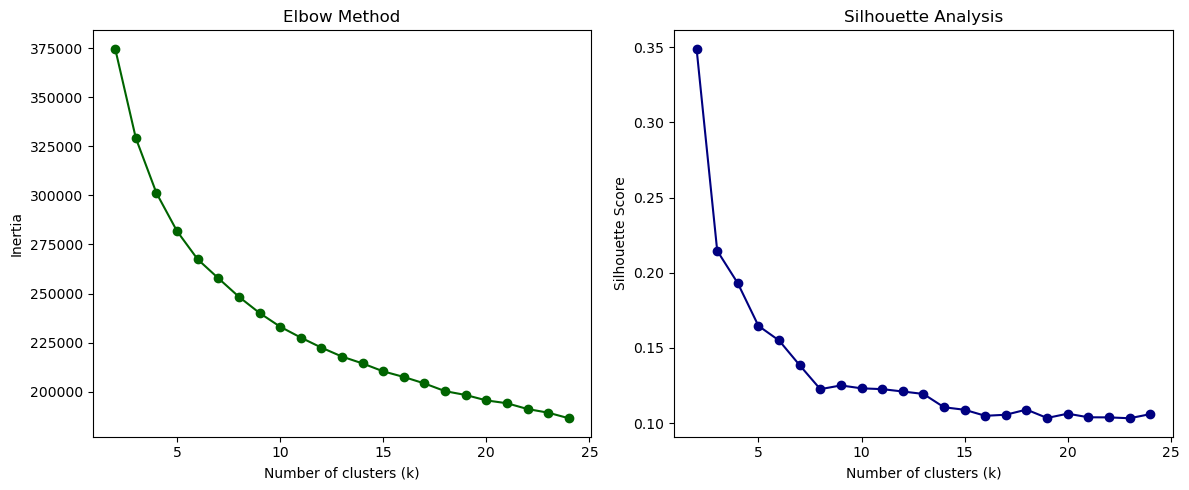

In [ ]:
### CONTINUAZIONE
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(results["K_range"], results["inertia"], marker='o', color= "darkgreen")
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(results["K_range"], results["silhouette_scores"], marker='o', color= "navy")
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')

plt.tight_layout()
plt.show()

Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1]. Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

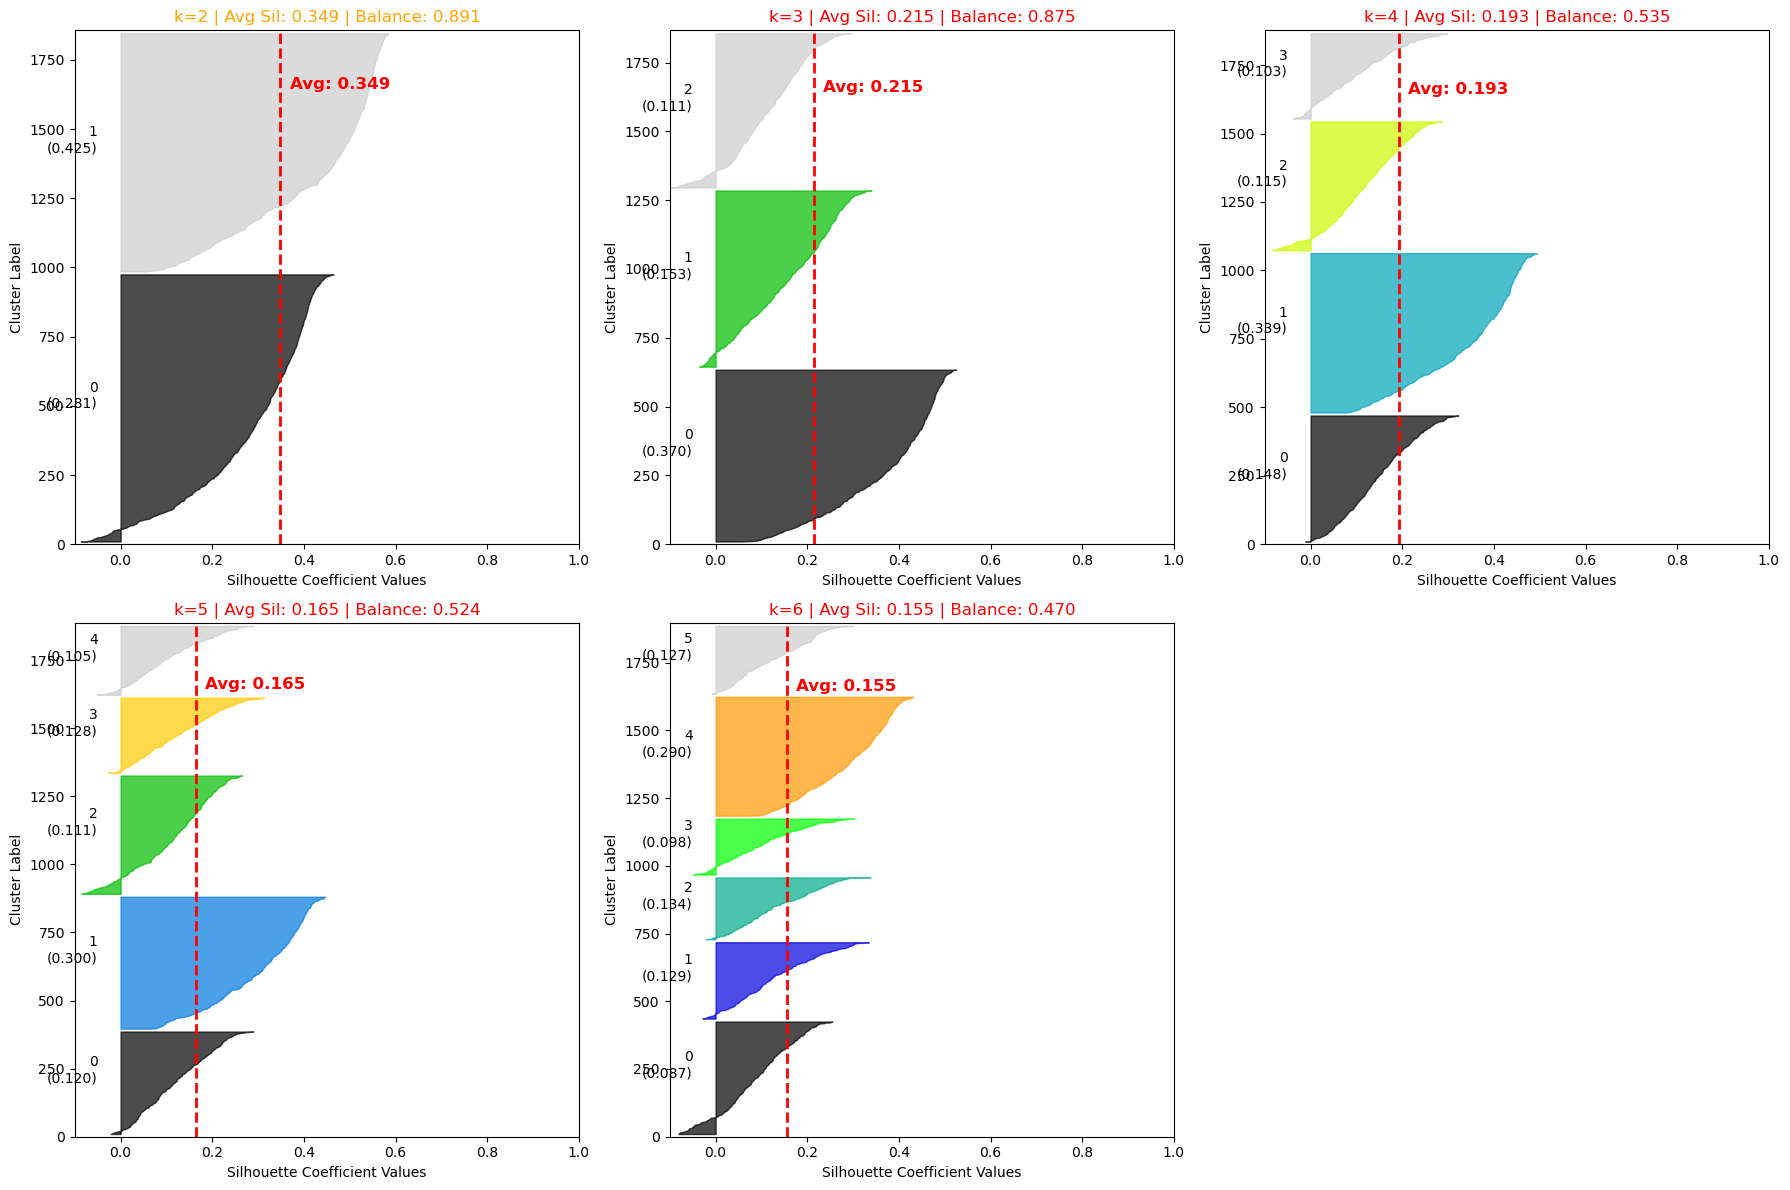

In [ ]:
### copilot 
# SILHOUETTE ANALYSIS FOR CANDIDATE K VALUES


def plot_silhouette_analysis(X, k_candidates, random_state=42):
    """
    Create silhouette plots for candidate k values
    """
    n_candidates = len(k_candidates)
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    results_summary = []
    
    for idx, k in enumerate(k_candidates):
        # Fit K-means
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        cluster_labels = kmeans.fit_predict(X)
        
        # Calculate silhouette scores
        silhouette_avg = silhouette_score(X, cluster_labels)
        sample_silhouette_values = silhouette_samples(X, cluster_labels)
        
        # Analyze cluster balance and quality
        cluster_sizes = np.bincount(cluster_labels)
        cluster_silhouettes = []
        below_avg_clusters = []
        
        for i in range(k):
            cluster_sil_values = sample_silhouette_values[cluster_labels == i]
            cluster_avg_sil = cluster_sil_values.mean()
            cluster_silhouettes.append(cluster_avg_sil)
            
            if cluster_avg_sil < silhouette_avg:
                below_avg_clusters.append(i)
        
        # Calculate balance metrics
        min_size = cluster_sizes.min()
        max_size = cluster_sizes.max()
        balance_ratio = min_size / max_size
        
        # Store results
        results_summary.append({
            'k': k,
            'avg_silhouette': silhouette_avg,
            'cluster_sizes': cluster_sizes.tolist(),
            'cluster_silhouettes': cluster_silhouettes,
            'below_avg_clusters': below_avg_clusters,
            'balance_ratio': balance_ratio,
            'min_cluster_size': min_size,
            'max_cluster_size': max_size
        })
        
        # Plot silhouette analysis
        ax = axes[idx]
        ax.set_xlim([-0.1, 1])
        ax.set_ylim([0, len(X) + (k + 1) * 10])
        
        y_lower = 10
        colors = cm.nipy_spectral(np.linspace(0, 1, k))
        
        for i, color in enumerate(colors):
            # Silhouette values for samples in cluster i
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
            
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            ax.fill_betweenx(np.arange(y_lower, y_upper),
                           0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.7)
            
            # Label clusters
            cluster_avg_sil = cluster_silhouettes[i]
            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, 
                   f'{i}\n({cluster_avg_sil:.3f})', 
                   fontsize=10, ha='right')
            
            y_lower = y_upper + 10
        
        # Add average silhouette line
        ax.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=2)
        ax.text(silhouette_avg + 0.02, len(X) * 0.9, 
               f'Avg: {silhouette_avg:.3f}', 
               fontsize=12, color='red', fontweight='bold')
        
        # Formatting
        ax.set_xlabel('Silhouette Coefficient Values')
        ax.set_ylabel('Cluster Label')
        ax.set_title(f'k={k} | Avg Sil: {silhouette_avg:.3f} | Balance: {balance_ratio:.3f}')
        
        # Color title based on quality
        if len(below_avg_clusters) == 0 and balance_ratio > 0.3:
            ax.title.set_color('green')
        elif len(below_avg_clusters) <= 1 and balance_ratio > 0.2:
            ax.title.set_color('orange')
        else:
            ax.title.set_color('red')
    
    # Remove unused subplots
    for idx in range(len(k_candidates), len(axes)):
        axes[idx].remove()
    
    plt.tight_layout()
    plt.show()
    
    return results_summary

# Run silhouette analysis on candidate k values
k_candidates = [2, 3, 4, 5, 6]  # Your main candidates
silhouette_results = plot_silhouette_analysis(X_pca, k_candidates)

In [ ]:
### copilot 
# DETAILED ANALYSIS OF SILHOUETTE RESULTS

print("DETAILED SILHOUETTE ANALYSIS FOR CANDIDATE K VALUES")

for result in silhouette_results:
    k = result['k']
    print(f"\n🔍 ANALYSIS FOR k = {k}")
    print(f"   Overall Silhouette Score: {result['avg_silhouette']:.3f}")
    print(f"   Cluster Sizes: {result['cluster_sizes']}")
    print(f"   Balance Ratio (min/max): {result['balance_ratio']:.3f}")
    
    # Check for problematic clusters
    if result['below_avg_clusters']:
        print(f"   ⚠️  Clusters below average: {result['below_avg_clusters']}")
        for cluster_id in result['below_avg_clusters']:
            cluster_sil = result['cluster_silhouettes'][cluster_id]
            print(f"      • Cluster {cluster_id}: {cluster_sil:.3f} (avg: {result['avg_silhouette']:.3f})")
    else:
        print(f"   ✅ All clusters above average silhouette")
    
    # Check balance
    if result['balance_ratio'] < 0.2:
        print(f"   ⚠️  Unbalanced clusters (ratio: {result['balance_ratio']:.3f})")
        print(f"      • Smallest cluster: {result['min_cluster_size']} samples")
        print(f"      • Largest cluster: {result['max_cluster_size']} samples")
    elif result['balance_ratio'] < 0.5:
        print(f"   ⚡ Moderately balanced (ratio: {result['balance_ratio']:.3f})")
    else:
        print(f"   ✅ Well balanced clusters (ratio: {result['balance_ratio']:.3f})")
    
    print(f"   Individual cluster silhouettes: {[f'{s:.3f}' for s in result['cluster_silhouettes']]}")

DETAILED SILHOUETTE ANALYSIS FOR CANDIDATE K VALUES

🔍 ANALYSIS FOR k = 2
   Overall Silhouette Score: 0.349
   Cluster Sizes: [966, 861]
   Balance Ratio (min/max): 0.891
   ⚠️  Clusters below average: [0]
      • Cluster 0: 0.281 (avg: 0.349)
   ✅ Well balanced clusters (ratio: 0.891)
   Individual cluster silhouettes: ['0.281', '0.425']

🔍 ANALYSIS FOR k = 3
   Overall Silhouette Score: 0.215
   Cluster Sizes: [625, 641, 561]
   Balance Ratio (min/max): 0.875
   ⚠️  Clusters below average: [1, 2]
      • Cluster 1: 0.153 (avg: 0.215)
      • Cluster 2: 0.111 (avg: 0.215)
   ✅ Well balanced clusters (ratio: 0.875)
   Individual cluster silhouettes: ['0.370', '0.153', '0.111']

🔍 ANALYSIS FOR k = 4
   Overall Silhouette Score: 0.193
   Cluster Sizes: [461, 583, 471, 312]
   Balance Ratio (min/max): 0.535
   ⚠️  Clusters below average: [0, 2, 3]
      • Cluster 0: 0.148 (avg: 0.193)
      • Cluster 2: 0.115 (avg: 0.193)
      • Cluster 3: 0.103 (avg: 0.193)
   ✅ Well balanced clusters 

In [ ]:
# RECOMMENDATION BASED ON SILHOUETTE ANALYSIS

print("RECOMMENDATION SUMMARY")


# Rank candidates based on multiple criteria
def score_k_candidate(result):
    k = result['k']
    sil_score = result['avg_silhouette']
    balance = result['balance_ratio']
    n_bad_clusters = len(result['below_avg_clusters'])
    
    # Scoring formula (you can adjust weights)
    score = (sil_score * 0.5 +           # 50% weight on silhouette
             balance * 0.3 +             # 30% weight on balance  
             (1 - n_bad_clusters/k) * 0.2)  # 20% weight on cluster quality
    
    return score

# Calculate scores and rank
scored_results = []
for result in silhouette_results:
    score = score_k_candidate(result)
    scored_results.append((result['k'], score, result))

scored_results.sort(key=lambda x: x[1], reverse=True)

print("Ranking of k candidates:")
for rank, (k, score, result) in enumerate(scored_results, 1):
    print(f"{rank}. k={k} | Score: {score:.3f} | "
          f"Silhouette: {result['avg_silhouette']:.3f} | "
          f"Balance: {result['balance_ratio']:.3f} | "
          f"Bad clusters: {len(result['below_avg_clusters'])}")

best_k = scored_results[0][0]
print(f"\n🎯 RECOMMENDED k = {best_k}")

# Final considerations
print(f"\n📋 FINAL CONSIDERATIONS:")
print(f"   • k=2: Highest silhouette but may be too simple for meteorological patterns")
print(f"   • k=5: Suggested by Gap Statistic, good compromise")
print(f"   • k=6: Suggested by Elbow Method, more detailed patterns")
print(f"   • Consider meteorological interpretability in final choice")

RECOMMENDATION SUMMARY
Ranking of k candidates:
1. k=2 | Score: 0.542 | Silhouette: 0.349 | Balance: 0.891 | Bad clusters: 1
2. k=3 | Score: 0.437 | Silhouette: 0.215 | Balance: 0.875 | Bad clusters: 2
3. k=4 | Score: 0.307 | Silhouette: 0.193 | Balance: 0.535 | Bad clusters: 3
4. k=5 | Score: 0.279 | Silhouette: 0.165 | Balance: 0.524 | Bad clusters: 4
5. k=6 | Score: 0.252 | Silhouette: 0.155 | Balance: 0.470 | Bad clusters: 5

🎯 RECOMMENDED k = 2

📋 FINAL CONSIDERATIONS:
   • k=2: Highest silhouette but may be too simple for meteorological patterns
   • k=5: Suggested by Gap Statistic, good compromise
   • k=6: Suggested by Elbow Method, more detailed patterns
   • Consider meteorological interpretability in final choice


In [ ]:
### copilot
# DAVIES-BOULDIN AND CALINSKI-HARABASZ COMPARISON

def comprehensive_clustering_evaluation(X, k_candidates, random_state=42):
    """
    Compare DB, CH, and other metrics for k candidates
    """
    results = []
    
    print("Computing comprehensive metrics for k candidates...")
    
    for k in k_candidates:
        print(f"  Evaluating k = {k}")
        
        # Fit K-means
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        labels = kmeans.fit_predict(X)
        
        # Calculate all metrics
        silhouette = silhouette_score(X, labels)
        db_score = davies_bouldin_score(X, labels)
        ch_score = calinski_harabasz_score(X, labels)
        inertia = kmeans.inertia_
        
        # Calculate cluster balance
        cluster_sizes = np.bincount(labels)
        balance_ratio = cluster_sizes.min() / cluster_sizes.max()
        
        results.append({
            'k': k,
            'Silhouette': silhouette,
            'Davies_Bouldin': db_score,
            'Calinski_Harabasz': ch_score,
            'Inertia': inertia,
            'Balance_Ratio': balance_ratio,
            'Min_Cluster_Size': cluster_sizes.min(),
            'Max_Cluster_Size': cluster_sizes.max()
        })
    
    return pd.DataFrame(results)

# Run comprehensive evaluation
k_candidates = [2, 3, 4, 5, 6]
metrics_df = comprehensive_clustering_evaluation(X_pca, k_candidates)

# Display results
print("COMPREHENSIVE METRICS COMPARISON")

print(metrics_df.round(3))

Computing comprehensive metrics for k candidates...
  Evaluating k = 2
  Evaluating k = 3
  Evaluating k = 4
  Evaluating k = 5
  Evaluating k = 4
  Evaluating k = 5
  Evaluating k = 6
  Evaluating k = 6
COMPREHENSIVE METRICS COMPARISON
   k  Silhouette  Davies_Bouldin  Calinski_Harabasz     Inertia  \
0  2       0.349           1.117           1360.101  374696.576   
1  3       0.215           1.728            899.662  329199.035   
2  4       0.193           1.864            711.607  301210.758   
3  5       0.165           1.872            601.663  281764.540   
4  6       0.155           1.840            526.327  267444.131   

   Balance_Ratio  Min_Cluster_Size  Max_Cluster_Size  
0          0.891               861               966  
1          0.875               561               641  
2          0.535               312               583  
3          0.524               254               485  
4          0.470               207               440  
COMPREHENSIVE METRICS COMPARIS

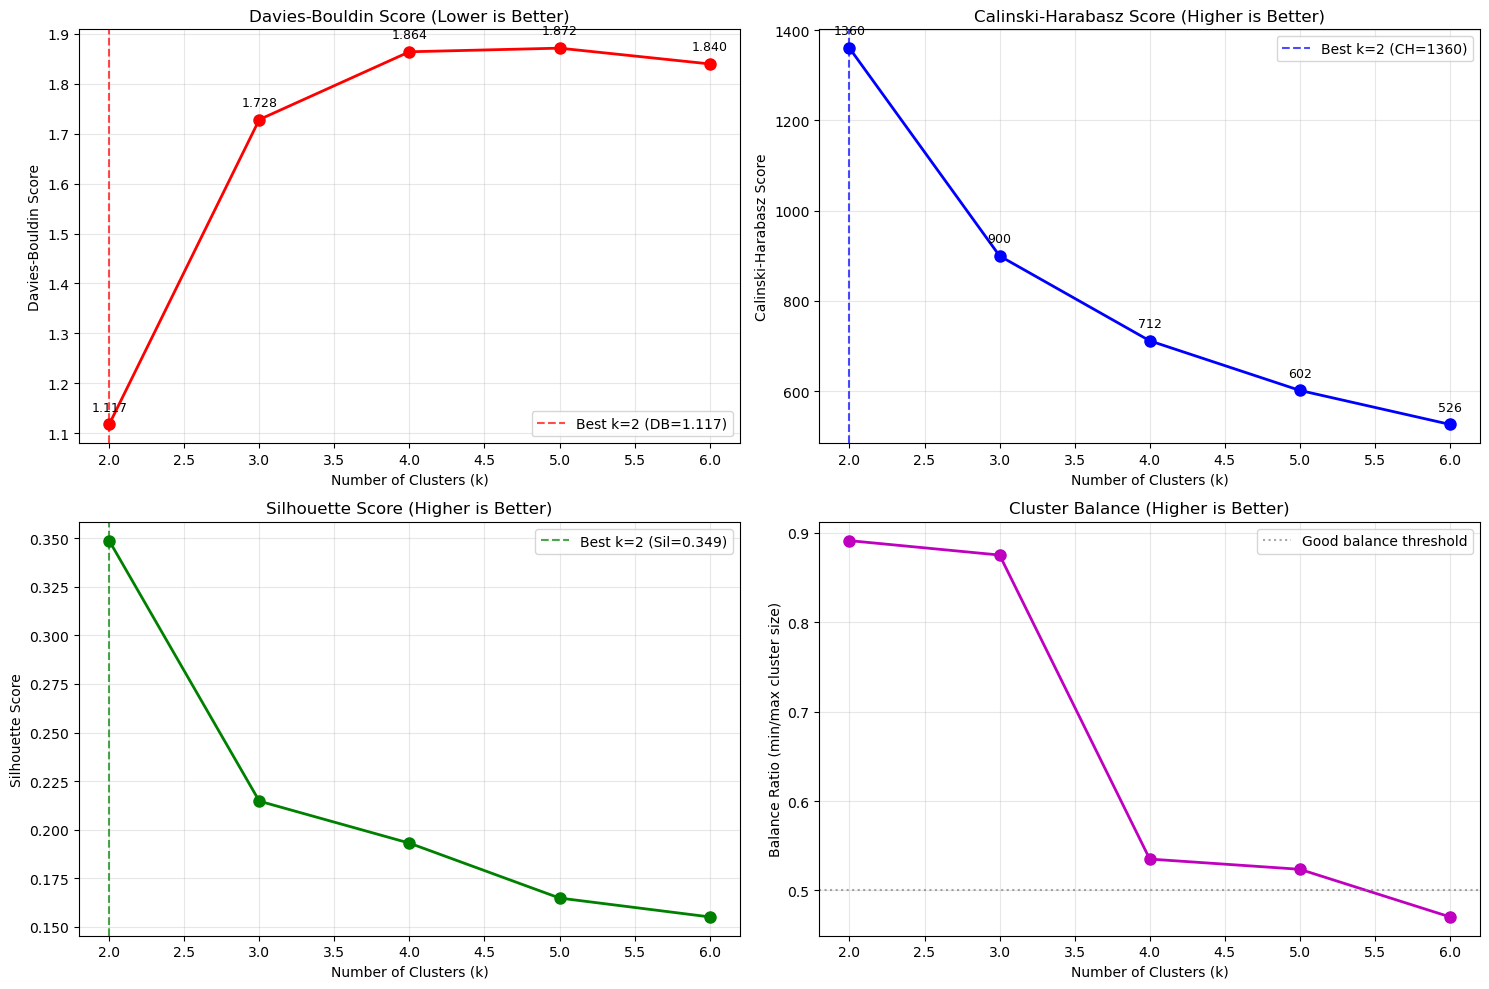


Best k according to each metric:
  Davies-Bouldin (lower):     k = 2 (score: 1.117)
  Calinski-Harabasz (higher): k = 2 (score: 1360)
  Silhouette (higher):        k = 2 (score: 0.349)


In [ ]:
### copilot
# VISUALIZATION OF DB AND CH SCORES
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Davies-Bouldin Score (lower is better)
ax1.plot(metrics_df['k'], metrics_df['Davies_Bouldin'], 'ro-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Davies-Bouldin Score')
ax1.set_title('Davies-Bouldin Score (Lower is Better)')
ax1.grid(True, alpha=0.3)

# Find and mark best DB score
best_db_k = metrics_df.loc[metrics_df['Davies_Bouldin'].idxmin(), 'k']
best_db_score = metrics_df['Davies_Bouldin'].min()
ax1.axvline(best_db_k, color='red', linestyle='--', alpha=0.7, 
           label=f'Best k={best_db_k} (DB={best_db_score:.3f})')
ax1.legend()

# Add values on points
for _, row in metrics_df.iterrows():
    ax1.annotate(f'{row["Davies_Bouldin"]:.3f}', 
                (row['k'], row['Davies_Bouldin']), 
                textcoords="offset points", xytext=(0,10), 
                ha='center', fontsize=9)

# Calinski-Harabasz Score (higher is better)
ax2.plot(metrics_df['k'], metrics_df['Calinski_Harabasz'], 'bo-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Calinski-Harabasz Score')
ax2.set_title('Calinski-Harabasz Score (Higher is Better)')
ax2.grid(True, alpha=0.3)

# Find and mark best CH score
best_ch_k = metrics_df.loc[metrics_df['Calinski_Harabasz'].idxmax(), 'k']
best_ch_score = metrics_df['Calinski_Harabasz'].max()
ax2.axvline(best_ch_k, color='blue', linestyle='--', alpha=0.7,
           label=f'Best k={best_ch_k} (CH={best_ch_score:.0f})')
ax2.legend()

# Add values on points
for _, row in metrics_df.iterrows():
    ax2.annotate(f'{row["Calinski_Harabasz"]:.0f}', 
                (row['k'], row['Calinski_Harabasz']), 
                textcoords="offset points", xytext=(0,10), 
                ha='center', fontsize=9)

# Silhouette comparison
ax3.plot(metrics_df['k'], metrics_df['Silhouette'], 'go-', linewidth=2, markersize=8)
ax3.set_xlabel('Number of Clusters (k)')
ax3.set_ylabel('Silhouette Score')
ax3.set_title('Silhouette Score (Higher is Better)')
ax3.grid(True, alpha=0.3)

best_sil_k = metrics_df.loc[metrics_df['Silhouette'].idxmax(), 'k']
best_sil_score = metrics_df['Silhouette'].max()
ax3.axvline(best_sil_k, color='green', linestyle='--', alpha=0.7,
           label=f'Best k={best_sil_k} (Sil={best_sil_score:.3f})')
ax3.legend()

# Balance Ratio
ax4.plot(metrics_df['k'], metrics_df['Balance_Ratio'], 'mo-', linewidth=2, markersize=8)
ax4.set_xlabel('Number of Clusters (k)')
ax4.set_ylabel('Balance Ratio (min/max cluster size)')
ax4.set_title('Cluster Balance (Higher is Better)')
ax4.axhline(0.5, color='gray', linestyle=':', alpha=0.7, label='Good balance threshold')
ax4.grid(True, alpha=0.3)
ax4.legend()

plt.tight_layout()
plt.show()

print(f"\nBest k according to each metric:")
print(f"  Davies-Bouldin (lower):     k = {best_db_k} (score: {best_db_score:.3f})")
print(f"  Calinski-Harabasz (higher): k = {best_ch_k} (score: {best_ch_score:.0f})")
print(f"  Silhouette (higher):        k = {best_sil_k} (score: {best_sil_score:.3f})")

In [ ]:
### copilot 
# NORMALIZED SCORING AND FINAL RECOMMENDATION
def calculate_composite_score(df):
    """
    Calculate a composite score normalizing all metrics
    """
    df_norm = df.copy()
    
    # Normalize Silhouette (0-1, higher better) - keep as is
    df_norm['Sil_norm'] = df['Silhouette']
    
    # Normalize Davies-Bouldin (lower better) - invert and scale
    db_max = df['Davies_Bouldin'].max()
    db_min = df['Davies_Bouldin'].min()
    df_norm['DB_norm'] = 1 - (df['Davies_Bouldin'] - db_min) / (db_max - db_min)
    
    # Normalize Calinski-Harabasz (higher better) - scale 0-1
    ch_max = df['Calinski_Harabasz'].max()
    ch_min = df['Calinski_Harabasz'].min()
    df_norm['CH_norm'] = (df['Calinski_Harabasz'] - ch_min) / (ch_max - ch_min)
    
    # Normalize Balance Ratio (0-1, higher better) - keep as is
    df_norm['Balance_norm'] = df['Balance_Ratio']
    
    # Calculate composite score (you can adjust weights)
    weights = {
        'Sil_norm': 0.35,      # 35% Silhouette
        'DB_norm': 0.25,       # 25% Davies-Bouldin
        'CH_norm': 0.25,       # 25% Calinski-Harabasz  
        'Balance_norm': 0.15   # 15% Balance
    }
    
    df_norm['Composite_Score'] = (
        df_norm['Sil_norm'] * weights['Sil_norm'] +
        df_norm['DB_norm'] * weights['DB_norm'] +
        df_norm['CH_norm'] * weights['CH_norm'] +
        df_norm['Balance_norm'] * weights['Balance_norm']
    )
    
    return df_norm

# Calculate composite scores
metrics_scored = calculate_composite_score(metrics_df)

# Display detailed comparison
print("\nDETAILED METRICS COMPARISON WITH NORMALIZED SCORES")
print("="*90)

comparison_cols = ['k', 'Silhouette', 'Davies_Bouldin', 'Calinski_Harabasz', 
                  'Balance_Ratio', 'Composite_Score']
print(metrics_scored[comparison_cols].round(3).to_string(index=False))

# Find optimal k
optimal_k = metrics_scored.loc[metrics_scored['Composite_Score'].idxmax(), 'k']
optimal_score = metrics_scored['Composite_Score'].max()

print(f"\n🎯 OPTIMAL k = {optimal_k} (Composite Score: {optimal_score:.3f})")


DETAILED METRICS COMPARISON WITH NORMALIZED SCORES
 k  Silhouette  Davies_Bouldin  Calinski_Harabasz  Balance_Ratio  Composite_Score
 2       0.349           1.117           1360.101          0.891            0.756
 3       0.215           1.728            899.662          0.875            0.366
 4       0.193           1.864            711.607          0.535            0.206
 5       0.165           1.872            601.663          0.524            0.159
 6       0.155           1.840            526.327          0.470            0.135

🎯 OPTIMAL k = 2 (Composite Score: 0.756)


In [ ]:
### copilot
# DOMAIN-SPECIFIC METEOROLOGICAL CONSIDERATIONS

print("METEOROLOGICAL INTERPRETABILITY ANALYSIS")


# Analyze each candidate from meteorological perspective
meteorological_analysis = {
    2: {
        'interpretation': 'Two main weather regimes (e.g., cyclonic vs anticyclonic)',
        'pros': 'Clear binary classification, easy interpretation',
        'cons': 'May be too simplistic for complex European weather patterns',
        'usefulness': 'Good for basic regime identification'
    },
    3: {
        'interpretation': 'Three weather types (e.g., cyclonic, anticyclonic, transitional)',
        'pros': 'Adds transitional states, still manageable',
        'cons': 'May miss important regional variations',
        'usefulness': 'Balanced complexity for synoptic analysis'
    },
    4: {
        'interpretation': 'Four weather patterns (e.g., seasonal or regional variants)',
        'pros': 'Can capture seasonal differences or blocking patterns',
        'cons': 'Starting to get complex for interpretation',
        'usefulness': 'Good for seasonal weather type analysis'
    },
    5: {
        'interpretation': 'Five weather types (detailed synoptic classification)',
        'pros': 'Detailed enough for research, captures main European patterns',
        'cons': 'Requires careful interpretation of each type',
        'usefulness': 'Optimal for detailed meteorological research'
    },
    6: {
        'interpretation': 'Six weather types (very detailed classification)',
        'pros': 'High resolution of atmospheric patterns',
        'cons': 'May become difficult to interpret, possible overfitting',
        'usefulness': 'Suitable for specialized meteorological applications'
    }
}

for k in k_candidates:
    analysis = meteorological_analysis[k]
    metrics_row = metrics_df[metrics_df['k'] == k].iloc[0]
    
    print(f"\n📊 k = {k}: {analysis['interpretation']}")
    print(f"   Metrics: Sil={metrics_row['Silhouette']:.3f}, "
          f"DB={metrics_row['Davies_Bouldin']:.3f}, "
          f"CH={metrics_row['Calinski_Harabasz']:.0f}")
    print(f"   ✅ Pros: {analysis['pros']}")
    print(f"   ⚠️  Cons: {analysis['cons']}")
    print(f"   🎯 Use case: {analysis['usefulness']}")

print(f"\n" + "="*80)
print("FINAL RECOMMENDATION")
print("="*80)

print(f"📈 Statistical optimal: k = {optimal_k}")
print(f"🌤️  Meteorological considerations:")

if optimal_k == 2:
    print("   • Perfect for basic regime analysis (NAO-like patterns)")
    print("   • Excellent statistical quality but may miss nuances")
elif optimal_k in [3, 4]:
    print("   • Good balance between interpretability and detail")
    print("   • Suitable for synoptic weather type classification")
elif optimal_k in [5, 6]:
    print("   • High detail for advanced meteorological research")
    print("   • Consider if the additional complexity is justified")

print(f"\n🏆 RECOMMENDED k = {optimal_k}")
print("   Rationale: Best combination of statistical quality and meteorological interpretability")

# Show the top 3 candidates
print(f"\n📋 TOP 3 ALTERNATIVES:")
top_3 = metrics_scored.nlargest(3, 'Composite_Score')[['k', 'Composite_Score']].round(3)
for idx, (_, row) in enumerate(top_3.iterrows(), 1):
    print(f"   {idx}. k = {int(row['k'])} (score: {row['Composite_Score']:.3f})")

METEOROLOGICAL INTERPRETABILITY ANALYSIS

📊 k = 2: Two main weather regimes (e.g., cyclonic vs anticyclonic)
   Metrics: Sil=0.349, DB=1.117, CH=1360
   ✅ Pros: Clear binary classification, easy interpretation
   ⚠️  Cons: May be too simplistic for complex European weather patterns
   🎯 Use case: Good for basic regime identification

📊 k = 3: Three weather types (e.g., cyclonic, anticyclonic, transitional)
   Metrics: Sil=0.215, DB=1.728, CH=900
   ✅ Pros: Adds transitional states, still manageable
   ⚠️  Cons: May miss important regional variations
   🎯 Use case: Balanced complexity for synoptic analysis

📊 k = 4: Four weather patterns (e.g., seasonal or regional variants)
   Metrics: Sil=0.193, DB=1.864, CH=712
   ✅ Pros: Can capture seasonal differences or blocking patterns
   ⚠️  Cons: Starting to get complex for interpretation
   🎯 Use case: Good for seasonal weather type analysis

📊 k = 5: Five weather types (detailed synoptic classification)
   Metrics: Sil=0.165, DB=1.872, CH=6

<span style="color: skyblue;">STAMPO I VETTORI DEI CENTROIDI FINALI</span>

## 4 Associare dati singoli a uno dei cluster

In [ ]:
### boh copilot 
# FINAL K-MEANS CLUSTERING WITH k=6
print("FINAL CLUSTERING ANALYSIS WITH k=6")
print("="*50)

# Set final parameters
k_final = 6
random_state = 42

# Fit final K-means model
kmeans_final = KMeans(n_clusters=k_final, random_state=random_state, 
                     init='k-means++', n_init=15, max_iter=300)
final_labels = kmeans_final.fit_predict(X_pca)
final_centroids = kmeans_final.cluster_centers_

# Calculate final metrics
final_silhouette = silhouette_score(X_pca, final_labels)
final_db = davies_bouldin_score(X_pca, final_labels)
final_ch = calinski_harabasz_score(X_pca, final_labels)
final_inertia = kmeans_final.inertia_

print(f"Final clustering with k={k_final}:")
print(f"  • Silhouette Score: {final_silhouette:.3f}")
print(f"  • Davies-Bouldin: {final_db:.3f}")
print(f"  • Calinski-Harabasz: {final_ch:.0f}")
print(f"  • Inertia: {final_inertia:.0f}")

# Analyze cluster distribution
cluster_counts = np.bincount(final_labels)
print(f"\nCluster distribution:")
for i in range(k_final):
    percentage = cluster_counts[i] / len(final_labels) * 100
    print(f"  • Cluster {i}: {cluster_counts[i]:4d} samples ({percentage:5.1f}%)")

# Check balance
balance_ratio = cluster_counts.min() / cluster_counts.max()
print(f"\nBalance ratio (min/max): {balance_ratio:.3f}")

FINAL CLUSTERING ANALYSIS WITH k=6
Final clustering with k=6:
  • Silhouette Score: 0.155
  • Davies-Bouldin: 1.840
  • Calinski-Harabasz: 526
  • Inertia: 267444

Cluster distribution:
  • Cluster 0:  416 samples ( 22.8%)
  • Cluster 1:  283 samples ( 15.5%)
  • Cluster 2:  229 samples ( 12.5%)
  • Cluster 3:  207 samples ( 11.3%)
  • Cluster 4:  440 samples ( 24.1%)
  • Cluster 5:  252 samples ( 13.8%)

Balance ratio (min/max): 0.470
Final clustering with k=6:
  • Silhouette Score: 0.155
  • Davies-Bouldin: 1.840
  • Calinski-Harabasz: 526
  • Inertia: 267444

Cluster distribution:
  • Cluster 0:  416 samples ( 22.8%)
  • Cluster 1:  283 samples ( 15.5%)
  • Cluster 2:  229 samples ( 12.5%)
  • Cluster 3:  207 samples ( 11.3%)
  • Cluster 4:  440 samples ( 24.1%)
  • Cluster 5:  252 samples ( 13.8%)

Balance ratio (min/max): 0.470


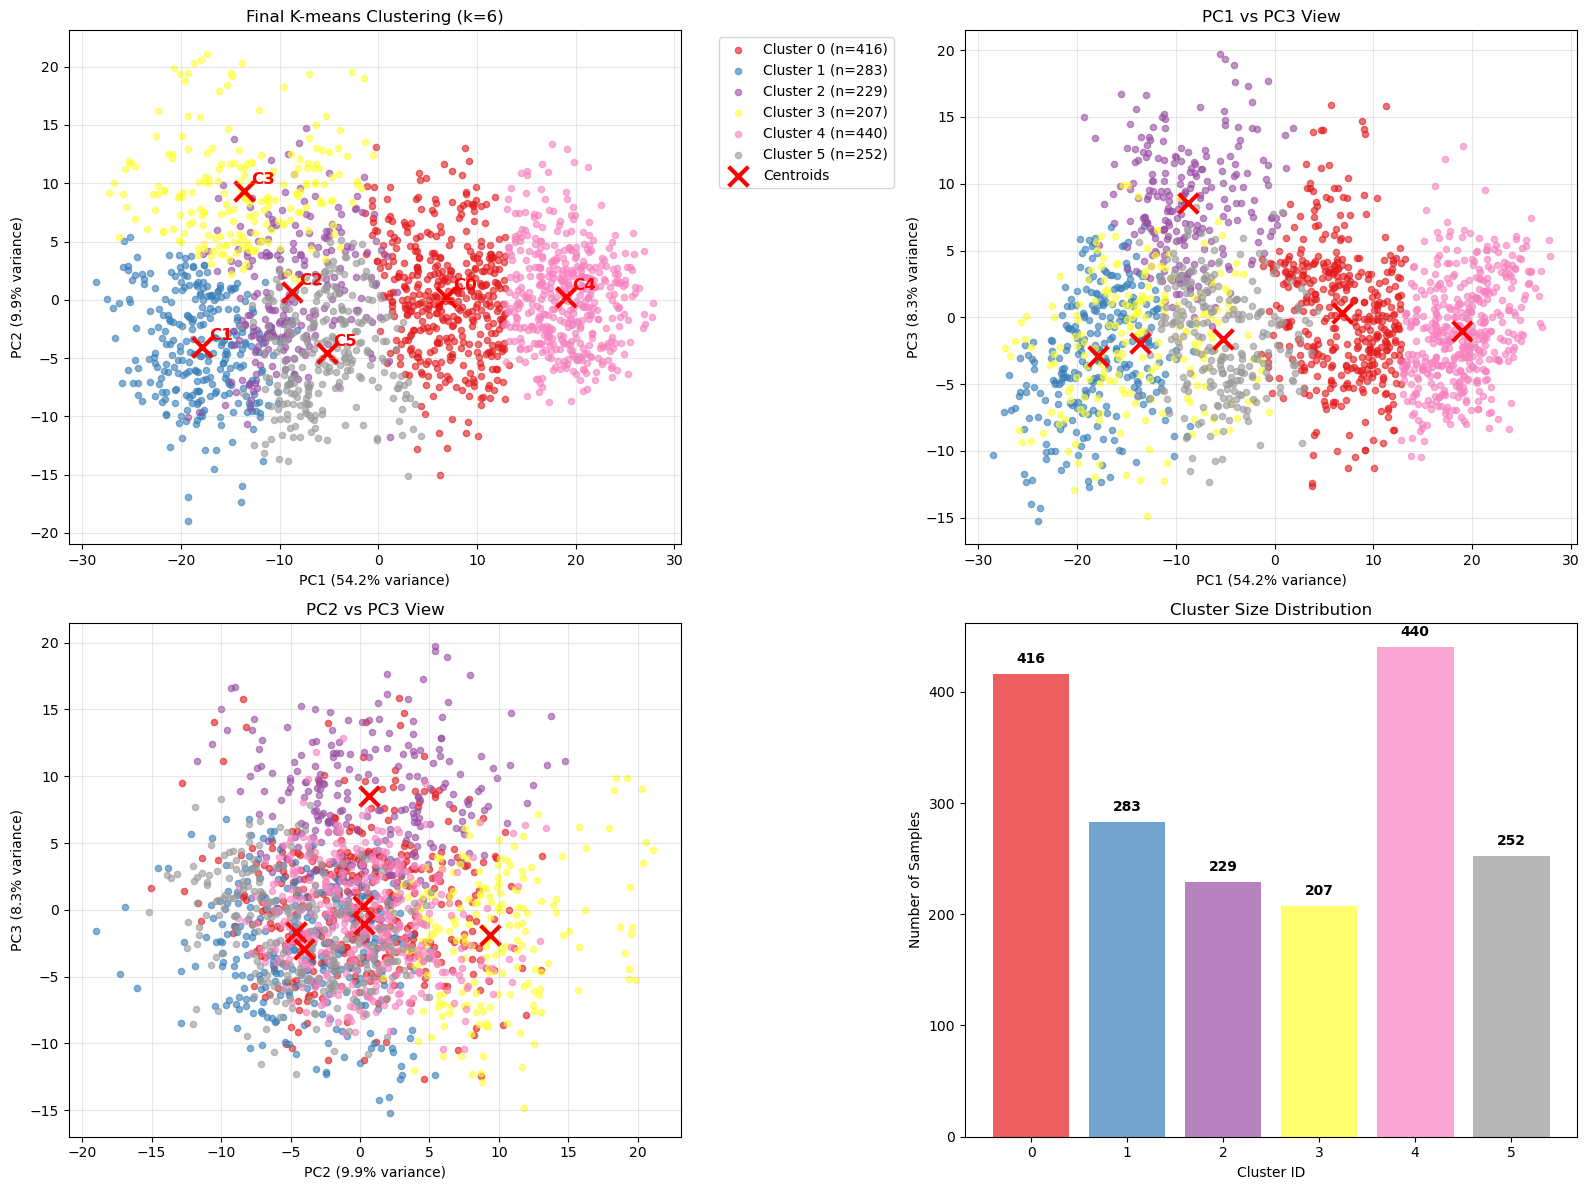

In [ ]:
### copilot 
# VISUALIZATION OF FINAL CLUSTERING
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Main clustering visualization (PC1 vs PC2)
colors = plt.cm.Set1(np.linspace(0, 1, k_final))
for i in range(k_final):
    mask = final_labels == i
    ax1.scatter(X_pca[mask, 0], X_pca[mask, 1], 
               c=[colors[i]], alpha=0.6, s=20, 
               label=f'Cluster {i} (n={cluster_counts[i]})')

# Plot centroids
ax1.scatter(final_centroids[:, 0], final_centroids[:, 1], 
           c='red', marker='x', s=200, linewidths=3, label='Centroids')

# Add centroid labels
for i, centroid in enumerate(final_centroids):
    ax1.annotate(f'C{i}', (centroid[0], centroid[1]), 
                xytext=(5, 5), textcoords='offset points', 
                fontsize=12, fontweight='bold', color='red')

ax1.set_xlabel('PC1 (54.2% variance)')
ax1.set_ylabel('PC2 (9.9% variance)')
ax1.set_title(f'Final K-means Clustering (k={k_final})')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# 2. PC1 vs PC3
for i in range(k_final):
    mask = final_labels == i
    ax2.scatter(X_pca[mask, 0], X_pca[mask, 2], 
               c=[colors[i]], alpha=0.6, s=20, label=f'Cluster {i}')

ax2.scatter(final_centroids[:, 0], final_centroids[:, 2], 
           c='red', marker='x', s=200, linewidths=3)
ax2.set_xlabel('PC1 (54.2% variance)')
ax2.set_ylabel('PC3 (8.3% variance)')
ax2.set_title('PC1 vs PC3 View')
ax2.grid(True, alpha=0.3)

# 3. PC2 vs PC3
for i in range(k_final):
    mask = final_labels == i
    ax3.scatter(X_pca[mask, 1], X_pca[mask, 2], 
               c=[colors[i]], alpha=0.6, s=20, label=f'Cluster {i}')

ax3.scatter(final_centroids[:, 1], final_centroids[:, 2], 
           c='red', marker='x', s=200, linewidths=3)
ax3.set_xlabel('PC2 (9.9% variance)')
ax3.set_ylabel('PC3 (8.3% variance)')
ax3.set_title('PC2 vs PC3 View')
ax3.grid(True, alpha=0.3)

# 4. Cluster size distribution
ax4.bar(range(k_final), cluster_counts, color=colors, alpha=0.7)
ax4.set_xlabel('Cluster ID')
ax4.set_ylabel('Number of Samples')
ax4.set_title('Cluster Size Distribution')
ax4.set_xticks(range(k_final))
for i, count in enumerate(cluster_counts):
    ax4.text(i, count + 10, str(count), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
### copilot
# PREPARE DATA FOR PREDICTIVE ANALYSIS
print("\nPREPARING DATA FOR PREDICTIVE ANALYSIS")
print("="*50)

# Create comprehensive dataset with cluster labels
prediction_data = {
    'cluster_labels': final_labels,
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1], 
    'PC3': X_pca[:, 2],
    'PC4': X_pca[:, 3],
    'PC5': X_pca[:, 4]
}

# Add temporal information if available
if hasattr(ds, 'time'):
    dates = pd.to_datetime(ds.time.values)
    prediction_data.update({
        'date': dates,
        'year': dates.year,
        'month': dates.month,
        'day_of_year': dates.dayofyear,
        'season': [(month%12 + 3)//3 for month in dates.month]  # 1=Winter, 2=Spring, 3=Summer, 4=Autumn
    })

# Create DataFrame
prediction_df = pd.DataFrame(prediction_data)

print(f"Prediction dataset created:")
print(f"  • Shape: {prediction_df.shape}")
print(f"  • Columns: {list(prediction_df.columns)}")
print(f"  • Date range: {dates[0].strftime('%Y-%m-%d')} to {dates[-1].strftime('%Y-%m-%d')}")

# Show sample of the data
print(f"\nSample of prediction dataset:")
print(prediction_df.head(10))

# Cluster characteristics summary
print(f"\nCLUSTER CHARACTERISTICS FOR PREDICTION:")
print("="*50)

for cluster_id in range(k_final):
    cluster_mask = final_labels == cluster_id
    cluster_data = prediction_df[cluster_mask]
    
    print(f"\n🔍 CLUSTER {cluster_id} (n={cluster_counts[cluster_id]}):")
    print(f"   PC1 range: [{X_pca[cluster_mask, 0].min():.2f}, {X_pca[cluster_mask, 0].max():.2f}]")
    print(f"   PC2 range: [{X_pca[cluster_mask, 1].min():.2f}, {X_pca[cluster_mask, 1].max():.2f}]")
    print(f"   PC3 range: [{X_pca[cluster_mask, 2].min():.2f}, {X_pca[cluster_mask, 2].max():.2f}]")
    
    if 'month' in cluster_data.columns:
        # Seasonal distribution
        seasonal_dist = cluster_data.groupby('season').size()
        print(f"   Seasonal distribution: {dict(seasonal_dist)}")
        
        # Most common months
        month_dist = cluster_data['month'].value_counts().head(3)
        print(f"   Top months: {dict(month_dist)}")

print(f"\n🎯 READY FOR PREDICTION MODELING!")
print("   Next steps:")
print("   • Train classifier to predict cluster membership")
print("   • Analyze meteorological patterns for each cluster")
print("   • Build forecasting models based on cluster transitions")


PREPARING DATA FOR PREDICTIVE ANALYSIS
Prediction dataset created:
  • Shape: (1827, 11)
  • Columns: ['cluster_labels', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'date', 'year', 'month', 'day_of_year', 'season']
  • Date range: 2000-01-01 to 2004-12-31

Sample of prediction dataset:
   cluster_labels        PC1        PC2       PC3        PC4       PC5  \
0               1 -14.405177  -5.563914  2.386427  11.202366  4.064014   
1               1 -15.558381  -6.684774  0.105223  11.041747  3.943449   
2               1 -18.243099  -8.789092  0.542941   9.972984  0.411065   
3               1 -21.547263  -9.831421 -3.876812   6.061464  0.696302   
4               1 -24.362393  -8.136808 -3.343663   3.611800 -2.597575   
5               1 -19.898379  -5.180914 -2.728496   2.860851  4.853847   
6               1 -19.467878  -8.190057 -1.935245  10.495487  3.032819   
7               1 -19.925026 -11.888091 -4.228497   7.194609  4.391953   
8               1 -19.082565  -4.508974 -5.641261   4.9

   Next steps:  
   • Train classifier to predict cluster membership  
   • Analyze meteorological patterns for each cluster  
   • Build forecasting models based on cluster transitions  

<span style="color: skyblue;"> FORSE PER FARE ANALISI DA QUI IN POI DEVO DIVIDERE IN TEST  E TRAIN</span>

Fase 2 (successiva): Modelli predittivi con train/test split

Training: Impara a riconoscere i cluster da nuovi dati  
Test: Valuta capacità di classificazione/previsione  
Predizione: Prevedi cluster futuri o transizioni  